# Предсказание стоимости машин по VIN-коду

**Цель:** составить модель, которая будет предсказывать цену автомобиля по её VIN-коду.

**Задачи:**
- изучить структуру VIN-кода, какие информационные компоненты он содержит (регион, производитель, характеристики автомобиля и т. д.).
- составить регулярные выражения для поиска и извлечения конкретных частей VIN-кода, таких как производитель, модель и год выпуска.
- распарсить текстовый массив данных с VIN-кодами и ценами.
- решить задачу предсказания цены по VIN-коду.

В нашем распоряжении имеются сырые данные по автомобилям Ford `vin_ford_train.txt` с VIN-кодами и ценами на автомобили, которым эти VIN-коды принадлежат.


## Подготовка данных

### Импортируем необходимые библиотеки

In [1]:
# !pip install catboost
# !pip install lxml
# !pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from category_encoders import MEstimateEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import shap

from sklearn.dummy import DummyRegressor

RANDOM_STATE=23042024

import warnings
warnings.filterwarnings("ignore")

### Парсинг данных из файла

#### Загрузим файл с данными `vin_ford_train.txt`

In [3]:
with open('vin_ford_train.txt', 'r', encoding="utf-8") as f:
    vin_ford_train = f.read()

In [4]:
vin_ford_train[:100]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421'

Видим в данных лишнюю информацию, будем иметь ввиду. При этом необходимые нам данные имеют формат [VIN-код:Цена]

#### Разрешенные символы

В VIN-коде запрещено использовать буквы `I, O, Q`. Все остальные буквы латинского алфавита и цифры от 0 до 9 использовать можно.

In [5]:
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']
ALLOWED = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
ALLOWED

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

#### Регулярные выражения

In [6]:
WMI = f'(?P<wmi>[{ALLOWED}]{{3}})'                                               # 1-3 производитель
BRAKE = f'(?P<brake>[{ALLOWED}])'                                                # 4 ремни безопасности, тормоза и грузоподъемность
MODEL = f'(?P<model>[{ALLOWED}]{{3}})'                                           # 5-7 модель
ENGINE = f'(?P<engine>[{ALLOWED}])'                                              # 8 двигатель
CHECK = f'(?P<check>[{ALLOWED}])'                                                # 9 контрольный знак
YEAR = f"(?P<year>[{ALLOWED.replace('U', '').replace('Z', '')}])"                # 10 год (в кодировке года не используются знаки U и Z)
FACTORY = f'(?P<factory>[{ALLOWED}])'                                            # 11 завод-производитель
SERIAL_NUM = f'(?P<serial_num>[{ALLOWED}]{{3}}\\d{{3}})'                         # 12-17 серийный номер

**Пример написания VIN-кода:**

`2FM|D|K3J|C|4|B|B|A41556` где
- 2FM - Производитель
- D - Ремни безопасности, тормоза и грузоподъемность
- K3J - Модель Ford Edge; SEL FWD ('10-'21), ST-Line FWD ('20-'21)
- C - Двигатель
- 4 - Контрольный знак
- B - Год (1981, 2011)
- B - Завод-производитель (Baltimore Assembly (Baltimore, Maryland) или Reatta Craft Centre/Lansing Craft Centre (Lansing Township, Michigan))
- A41556 - Серийный номер

In [7]:
vin_ford = f'{WMI}{BRAKE}{MODEL}{ENGINE}{CHECK}{YEAR}{FACTORY}{SERIAL_NUM}'
price_ford = r'(?P<price>\d+)'

In [8]:
data_ford = re.compile(f"\\[{vin_ford}:{price_ford}\\]")

In [9]:
values = []
for x in data_ford.finditer(vin_ford_train):
    values.append(x.groupdict())

values[:1] #Выведем первую строчку c VIN-кодом и ценой

[{'wmi': '2FM',
  'brake': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'factory': 'B',
  'serial_num': 'A41556',
  'price': '12500'}]

#### Проверка корректности формата VIN-кода

- Вин-код состоит из 17 знаков – цифр и букв, кроме 'I', 'O', 'Q'
- Последние три знака – всегда цифры
- Цена состоит из цифр, без лишних пробелов и знаков

In [10]:
valid_vin = r'(\w{14}\d{3})'
valid_price = r'(\d+)'

invalid_vin = r'(?!\w{14}\d{3})(\w+)'
invalid_price = r'(?!\d+)(\w+)'

invalid_options = [
    f"\\[{invalid_vin}:{invalid_price}\\]",
    f"\\[{valid_vin}:{invalid_price}\\]",
    f"\\[{invalid_vin}:{valid_price}\\]"
]

invalid_pattern = re.compile('(?P<invalid_data> ' + '|'.join(invalid_options) + ')')
invalid_values = []
for x in invalid_pattern.finditer(vin_ford_train):
    invalid_values.append(x.groupdict())

invalid_values

[{'invalid_data': '[1FM5K8D83DGB91002:XXXX]'},
 {'invalid_data': '[1FM5K8D83DGB9100X:26600]'}]

Видим, что в данных есть две строчки, где некорректно записан VIN. Чтобы они не попали в наш рабочий датасет, в регулярном выражении для парсинга данных прописаны условия, которые не дадут данным строчкам спарситься (указано, что 3 последних знака это обязательно цифры и цена тоже обязательно является набором чисел)

### Создадим датасет из спарсенных данных

In [11]:
df = pd.DataFrame(values)
df.head(10)

,wmi,brake,model,engine,check,year,factory,serial_num,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600
5,1FM,5,K8D,8,2,D,G,A16143,26400
6,1FT,F,W1C,F,X,C,F,C23663,14000
7,2FM,D,K3J,C,6,C,B,A90002,19500
8,1FT,F,W1C,T,8,D,K,D06233,24400
9,1FM,Z,U64,W,1,3,U,C28949,2900


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wmi         71884 non-null  object
 1   brake       71884 non-null  object
 2   model       71884 non-null  object
 3   engine      71884 non-null  object
 4   check       71884 non-null  object
 5   year        71884 non-null  object
 6   factory     71884 non-null  object
 7   serial_num  71884 non-null  object
 8   price       71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


Видим, что тип всех данных - `object`, значения цены лучше перевести в `int`. Пропусков нет, что хорошо.

In [13]:
df['price'] = df['price'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wmi         71884 non-null  object
 1   brake       71884 non-null  object
 2   model       71884 non-null  object
 3   engine      71884 non-null  object
 4   check       71884 non-null  object
 5   year        71884 non-null  object
 6   factory     71884 non-null  object
 7   serial_num  71884 non-null  object
 8   price       71884 non-null  int32 
dtypes: int32(1), object(8)
memory usage: 4.7+ MB


## Проведем исследовательский анализ данных

#### Проверим дубликаты

In [14]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


#### Проверим пропуски

In [15]:
print("Количество пропусков:", df.isnull().sum().sum())

Количество пропусков: 0


#### Зависимость цены от года выпуска авто

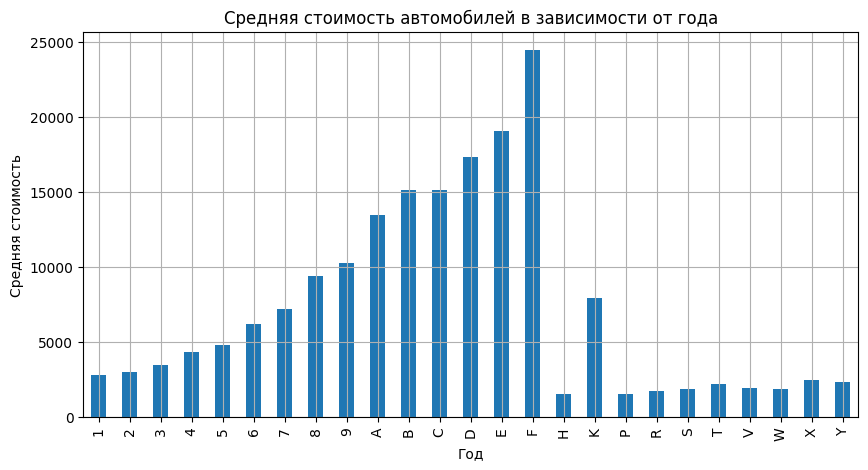

In [16]:
mean_in_years = df.groupby('year')['price'].mean().plot(
    x='year',
    kind='bar',
    figsize=(10, 5),
    grid=True,
    title = 'Cредняя стоимость автомобилей в зависимости от года'
)
plt.xlabel('Год')
plt.ylabel('Cредняя стоимость')
plt.show()

#### Количество выпущенных авто в зависимости от года выпуска

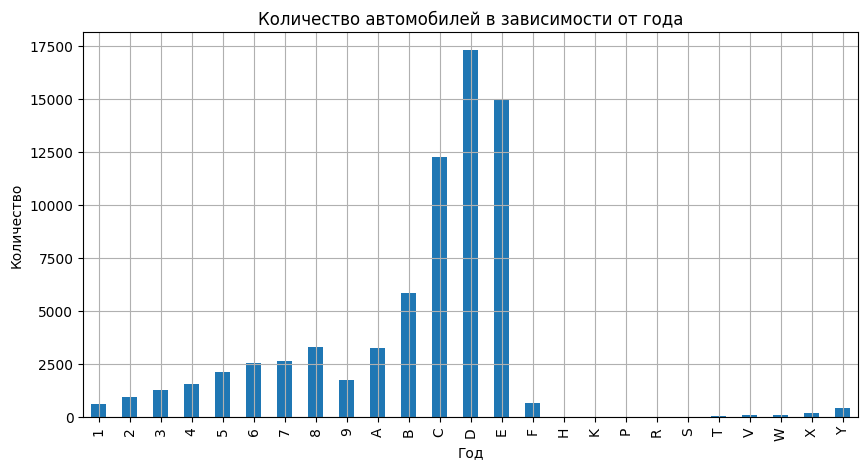

In [17]:
car_in_years = df.groupby('year')['year'].count().plot(
    x='year',
    kind='bar',
    figsize=(10, 5),
    grid=True,
    title = 'Количество автомобилей в зависимости от года'
)
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

In [18]:
df_gr = df.groupby('year')['year'].count()
df_gr

year
1      601
2      951
3     1274
4     1559
5     2105
6     2555
7     2652
8     3277
9     1736
A     3262
B     5860
C    12254
D    17286
E    14990
F      653
H        1
K        1
P        1
R        6
S       20
T       30
V       88
W      113
X      194
Y      415
Name: year, dtype: int64

Видим, что года с 1-9 и с A-F средняя стоимость автомобиля растет и в год F (1985, 2015) достигает своего пика. При этом если посмотреть на количество автомобилей в год F, то их там очень-очень мало - всего 653, а пик количества авто приходится на год D (1983, 2013). Объяснить это сложно, возможно, это особенности выгруженных данных (возможно, данные взяты за начало 2015 года и т.д.). При этом средняя стоимость 653 автомобилей за год F больше стоимости 17286 автомобилей за год D - интересно, возможно в выборку попали новые авто 2015 года (F) и старые авто 1983 года (D).

#### Проверим столбец с ценой (price)

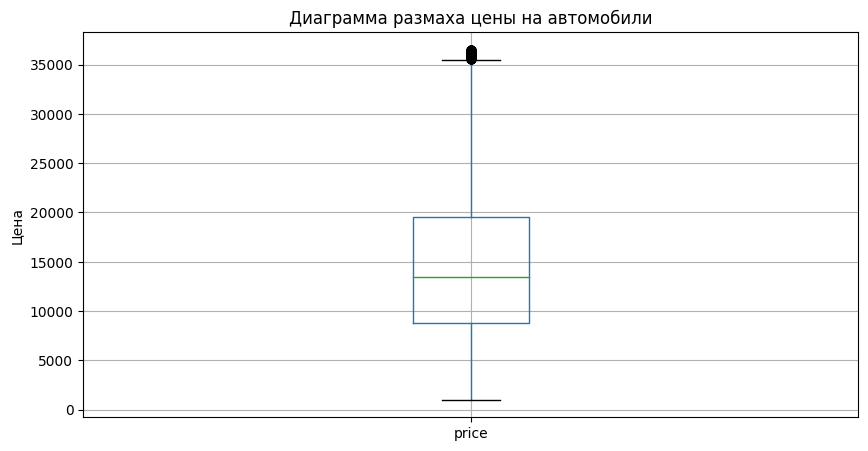

In [19]:
plt.figure(figsize=(10,5))
df.boxplot(column=['price'])
plt.ylim()
plt.title('Диаграмма размаха цены на автомобили')
plt.ylabel('Цена')
plt.show()

In [20]:
df['price'].describe()

count    71884.000000
mean     14321.449377
std       7827.057238
min       1000.000000
25%       8800.000000
50%      13500.000000
75%      19500.000000
max      36500.000000
Name: price, dtype: float64

Тут все нормально, есть автомобили за 36500, есть за 1000, вполне похоже на реальные цены за автомобили Ford.

#### Посмотрим кто из производителей (wmi) имеет наибольшую выручку

In [21]:
wmi_vin = df.groupby('wmi').agg({'price':'sum'}).reset_index()
wmi_vin.sort_values(by='price', ascending=False)

,wmi,price
4,1FT,289653284
3,1FM,277011984
9,3FA,147905484
0,1FA,133667683
7,2FM,106368726
5,1ZV,49261924
1,1FB,20663407
2,1FD,2702625
11,4F2,873450
6,2FA,613050


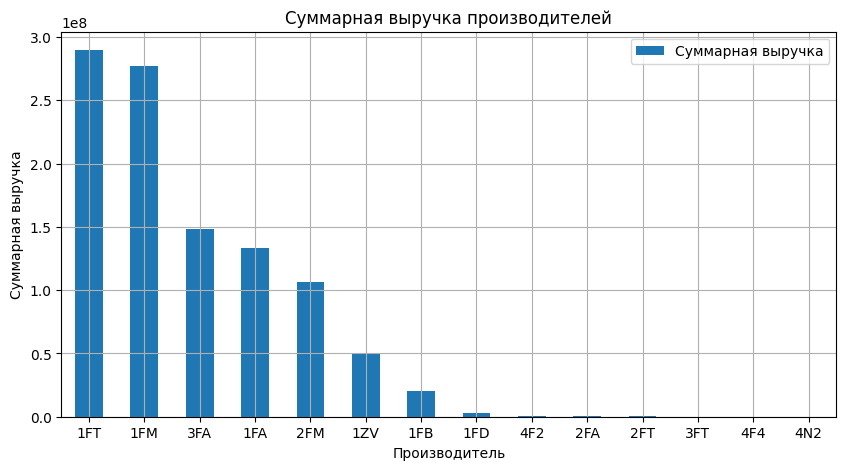

In [22]:
wmi_vin.sort_values(by='price', ascending=False).plot(
    x='wmi',
    kind='bar',
    figsize=(10, 5),
    grid=True,
    title = 'Суммарная выручка производителей'
)
plt.legend(['Суммарная выручка'])
plt.xticks(rotation=0)
plt.xlabel('Производитель')
plt.ylabel('Суммарная выручка')
plt.show()

In [23]:
ford_wmi = {
    '1FT': 'Ford truck',
    '1FM': 'Ford MPV/SUV',
    '3FA': 'Ford car',
    '1FA': 'Ford car',
    '2FM': 'Ford MPV/SUV',
    '1ZV': 'Ford made by AutoAlliance International',
    '1FB': 'Ford "bus" (van with more than 3 rows of seats)',
    '1FD': 'Ford incomplete vehicle',
    '4F2': 'Mazda SUV made by Ford',
    '2FA': 'Ford car',
    '2FT': 'Ford truck',
    '3FT': 'Ford truck',
    '4F4': 'Mazda truck made by Ford',
    '4N2': 'Nissan Quest made by Ford'
}

Лидерами по выручке в нашем датасете являются производители с кодами 1FT (Ford truck) и 1FM (Ford MPV/SUV).

**Найдем лидера по средней цене**

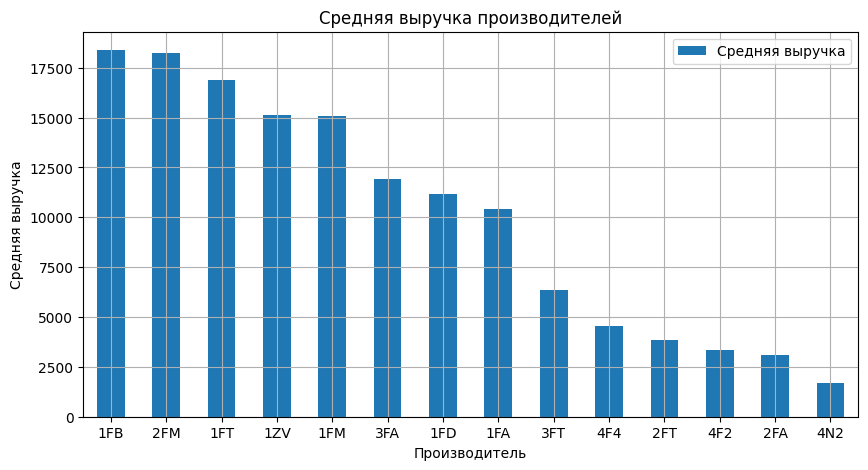

In [24]:
df.groupby('wmi').agg({'price':'mean'}).reset_index().sort_values(by='price', ascending=False).plot(
    x='wmi',
    kind='bar',
    figsize=(10, 5),
    grid=True,
    title = 'Средняя выручка производителей'
)
plt.legend(['Средняя выручка'])
plt.xticks(rotation=0)
plt.xlabel('Производитель')
plt.ylabel('Средняя выручка')
plt.show()

Тут интересно увидеть, что большая средняя выручка у 1FB, хотя в суммарной выручке выше данный производитель даже не в топ-5.

#### Посмотрим модель, имеющую наибольшую выручку

In [25]:
model_vin = df.groupby('model').agg({'price':'sum'}).reset_index()
model_vin = model_vin.sort_values(by='price', ascending=False).head(10)
model_vin

,model,price
314,W1E,99722023
106,P0H,78769608
144,P3F,39963141
91,K8D,30503364
313,W1C,24863375
67,K3J,23743950
236,U0G,22798805
342,X1E,21985500
148,P3K,21782903
92,K8F,20792250


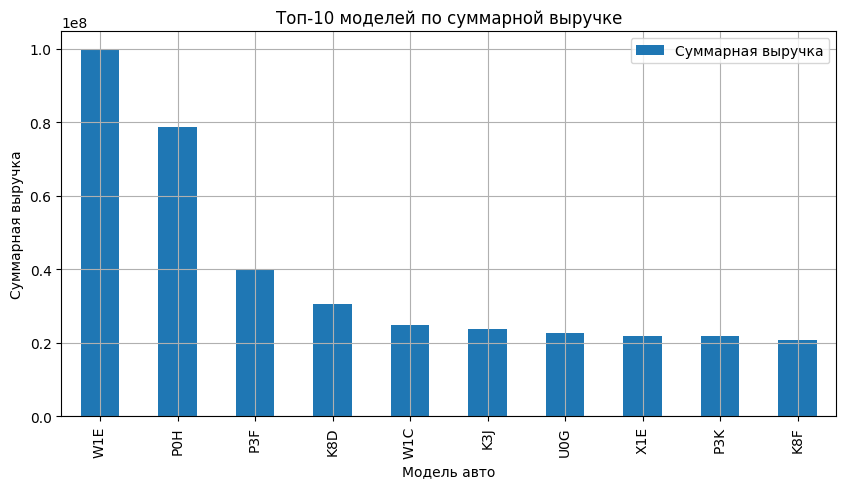

In [26]:
model_vin.sort_values(by='price', ascending=False).plot(
    x='model',
    kind='bar',
    figsize=(10, 5),
    grid=True,
    title = 'Топ-10 моделей по суммарной выручке'
)
plt.legend(['Суммарная выручка'])
plt.xticks(rotation=90)
plt.xlabel('Модель авто')
plt.ylabel('Суммарная выручка')
plt.show()

Особо выделяются модели W1E (*Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD ('10-'23)*) и P0H (*Ford Fusion; SE, FWD ('13-'20)*).

In [27]:
df['model'].value_counts()

model
P0H    6171
P3F    3931
W1E    3897
P3K    1958
P0J    1487
       ... 
R2Y       1
X15       1
K30       1
P7A       1
F25       1
Name: count, Length: 365, dtype: int64

In [28]:
model_vin_mean = df.groupby('model').agg({'price':'mean'}).reset_index()
model_vin_mean = model_vin_mean.sort_values(by='price', ascending=False).head(10)
model_vin_mean

,model,price
93,K8G,33595.953757
351,X2X,33250.000000
190,P8J,33177.272727
315,W1R,33162.500000
343,X1R,33125.000000
223,T89,32000.000000
331,W4D,30912.500000
222,T88,30000.000000
328,W3D,29957.894737
57,K1J,29779.517073


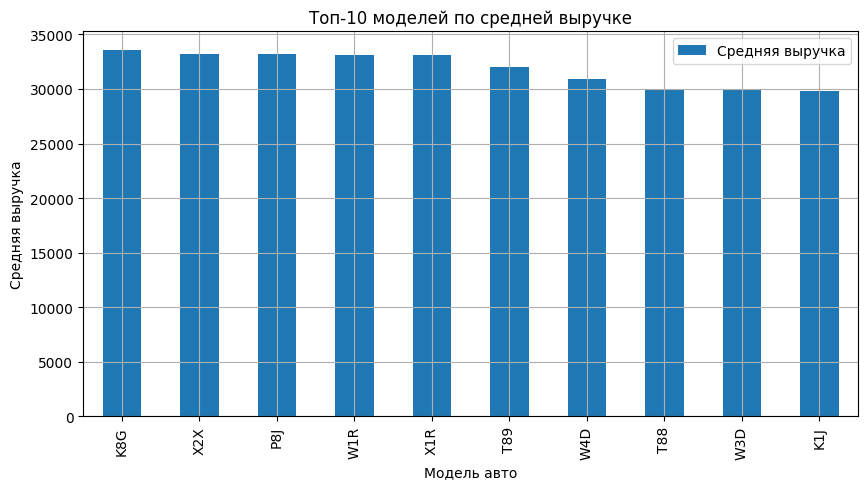

In [29]:
model_vin_mean.sort_values(by='price', ascending=False).plot(
    x='model',
    kind='bar',
    figsize=(10, 5),
    grid=True,
    title = 'Топ-10 моделей по средней выручке'
)
plt.legend(['Средняя выручка'])
plt.xticks(rotation=90)
plt.xlabel('Модель авто')
plt.ylabel('Средняя выручка')
plt.show()

По средней выручке можно выделить сразу 5 авто:

- K8G (*Ford Explorer; Sport, AWD ('13-'19)*)
- X2X (*Ford Transit 350, Passenger Van, High Roof, Sliding Passenger-Side Cargo Door ('15-'19)*)
- P8J (*Ford Mustang, Coupe; Shelby GT350/GT350R ('15-'20)*)
- W1R (*Ford F-Series, F-150 Raptor, SuperCrew (Crew Cab), Styleside, 4WD ('11-'14, '17-'23)*)
- X1R (*Ford F-Series, F-150 Raptor, Super Cab, Styleside, 4WD ('11-'14, '17-'20)*)


## Спарсим таблицы для расшифровки VIN-кода

In [30]:
list_of_tables = pd.read_html('https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Ford/VIN_Codes#American_models')

In [31]:
len(list_of_tables)

26

**1-3 значение в VIN-коде (производитель)**

In [32]:
df_wmi_1_3 = list_of_tables[24]
df_wmi_1_3

,WMI,Country,Description,Vehicle types
0,AFA,South Africa,Ford Motor Company of Southern Africa,NaN
1,JC0,Japan,Ford (made by Mazda),NaN
2,JC2,Japan,Ford Courier pickup (made by Mazda),NaN
3,KNJ,South Korea,Ford (made by Kia),NaN
4,LFA,Taiwan,Ford Lio Ho,NaN
...,...,...,...,...
77,7A5,New Zealand,Ford New Zealand,NaN
78,8AF,Argentina,Ford Argentina,NaN
79,8XD,Venezuela,Ford Motor Venezuela,NaN
80,9BF,Brazil,Ford Brazil,NaN


In [33]:
df_wmi_1_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   WMI            82 non-null     object
 1   Country        82 non-null     object
 2   Description    82 non-null     object
 3   Vehicle types  50 non-null     object
dtypes: object(4)
memory usage: 2.7+ KB


In [34]:
df_wmi_1_3['WMI'].nunique()

82

**4 значение в VIN-коде (ремни безопасности, тормоза и грузоподъемность)**

In [35]:
df_brake_4 = list_of_tables[4]
df_brake_4

,VIN code,Description
0,B,Active belts (Manual)
1,P,Passive belts (Motorized)
2,C,Active Belts and Driver-side Front Airbag
3,A,Active (Manual) Belt (Driver) & Passive (Motor...
4,L,Active Belts and Driver and Passenger (First G...
5,F,Active Belts and Driver and Passenger (Second ...
6,K,Active Belts and Driver and Passenger (Second ...
7,H,Active Belts and Driver and Passenger Front an...
8,B,Active Belts plus Driver and Passenger Front A...
9,H,Active Belts plus Driver and Passenger Front A...


In [36]:
df_brake_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   VIN code     13 non-null     object
 1   Description  13 non-null     object
dtypes: object(2)
memory usage: 340.0+ bytes


**8 значение в VIN-коде (двигатель)**

In [37]:
df_engine_8 = list_of_tables[9]
df_engine_8

,Configuration,Name,Displacement,Description,Fuel,Power (hp),Power (kW),VIN code,Notes/Applications
0,I3,Fox,1.0 L,DOHC 12V Ti-VCT DI Turbo IC (EcoBoost),Gasoline,123,91,E,"Ford Fiesta ('14-'17), Ford Focus ('15-'18)"
1,I4,Lima (LL23),2.3 L,2-bbl. SOHC 8V,Gasoline,86-88,63-65,A,"Ford Mustang, Mercury Capri, Ford Fairmont, Me..."
2,I4,Lima (LL23),2.3 L,2-bbl. SOHC 8V,Propane,86,63,6,"Ford Granada, Mercury Cougar ('82)"
3,I4,Lima (LL23),2.3 L,1-bbl. SOHC 8V,Gasoline,88-90,65-66,A,"Ford Mustang, Mercury Capri ('83-'86), Ford Fa..."
4,I4,Lima (LL23),2.3 L,1-bbl. SOHC 8V,Propane,88,65,6,"Ford LTD, Mercury Marquis ('83-'84)"
...,...,...,...,...,...,...,...,...,...
122,V8,Coyote,"5.0 L (5,035 cc)",Port/Direct injection DOHC 32V Ti-VCT,Gasoline,470-480-500,346-353-368,0,"Gen 6: Ford Mustang Bullitt ('19-'20), Ford Mu..."
123,V8,Voodoo,5.2 L,SEFI DOHC 32V Ti-VCT Flat-Plane Crank,Gasoline,526,387,Z,Ford Mustang Shelby GT350/ GT350R ('15-'20)
124,V8,Predator,5.2 L,SEFI DOHC 32V Ti-VCT SC IC,Gasoline,760,559,J,Ford Mustang Shelby GT500 ('20-'22)
125,V8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_engine_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Configuration       127 non-null    object
 1   Name                125 non-null    object
 2   Displacement        125 non-null    object
 3   Description         125 non-null    object
 4   Fuel                125 non-null    object
 5   Power (hp)          125 non-null    object
 6   Power (kW)          125 non-null    object
 7   VIN code            125 non-null    object
 8   Notes/Applications  125 non-null    object
dtypes: object(9)
memory usage: 9.1+ KB


**10 значение в VIN-коде (Год выпуска авто)**

In [39]:
df_year_10 = pd.read_html('https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Model_year')
df_year_10 = df_year_10[0]
df_year_10

,Code,Years
0,A,"1980, 2010"
1,B,"1981, 2011"
2,C,"1982, 2012"
3,D,"1983, 2013"
4,E,"1984, 2014"
5,F,"1985, 2015"
6,G,"1986, 2016"
7,H,"1987, 2017"
8,J,"1988, 2018"
9,K,"1989, 2019"


In [40]:
df_year_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    30 non-null     object
 1   Years   30 non-null     object
dtypes: object(2)
memory usage: 612.0+ bytes


**11 значение в VIN-коде (Завод-изготовитель)**

In [41]:
df_factory_11 = list_of_tables[14]
df_factory_11

,VIN code,Location,Notes
0,A,"Atlanta Assembly (Hapeville, Georgia)",through 2007 model year
1,B,"Oakville Assembly (Oakville, Ontario, Canada)",NaN
2,C,"Ontario Truck (Oakville, Ontario, Canada)",through 2004 model year
3,D,"Ohio Assembly (Avon Lake, Ohio)",NaN
4,E,"Kentucky Truck Assembly (Louisville, Kentucky)",For light duty vehicles (pickups/chassis cab p...
5,F,"Dearborn Assembly (Dearborn, Michigan)",through 2004 model year
6,F,"Dearborn Truck Assembly (Dearborn, Michigan)",since 2005 model year
7,G,"Chicago Assembly (Chicago, Illinois)",NaN
8,H,"Lorain Assembly (Lorain, Ohio)",through 2006 model year
9,H,"Multimatic, Inc. plant (Markham, Ontario, Canada)",from 2017-2022 model year


In [42]:
df_factory_11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   VIN code  31 non-null     object
 1   Location  31 non-null     object
 2   Notes     24 non-null     object
dtypes: object(3)
memory usage: 876.0+ bytes


**5-7 значение в VIN-коде (модель авто)**

In [43]:
web_table = """
<table class="wikitable">
<tbody><tr>
<th>VIN Code
</th>
<th>Model
</th></tr>
<tr>
<td>A11%A14%A15%A21%A24%A25%A31%A34%A35%A41%A44%A45
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Aerostar" class="extiw" title="w:Ford Aerostar">Ford Aerostar</a> regular length passenger van ('86-'97) %
Ford Aerostar regular length cargo van ('86-'97) %
Ford Aerostar regular length cargo van w/side windows ('86-'94) %
Ford Aerostar regular length passenger van 4WD ('90-'94) %
Ford Aerostar regular length cargo van 4WD ('90-'94) %
Ford Aerostar regular length cargo van w/side windows 4WD ('90-'94) %
Ford Aerostar extended length passenger van ('89-'97) %
Ford Aerostar extended length cargo van ('89-'94) %
Ford Aerostar extended length cargo van w/side windows ('89-'94) %
Ford Aerostar extended length passenger van 4WD ('90-'97) %
Ford Aerostar extended length cargo van 4WD ('90-'94) %
Ford Aerostar extended length cargo van w/side windows 4WD ('90-'94) %
</p>
</td></tr>
<tr>
<td>A51%A50%A51%A52%A53%A54%A57%A58
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Windstar" class="extiw" title="w:Ford Windstar">Ford Windstar</a> passenger van ('95-'98) %
Ford Windstar Base model ('00), LX 3-door ('01), LX Base ('02), Base model ('03) %
Ford Windstar LX ('99-'00), LX 4-door ('01), LX Standard, LX Deluxe ('02-'03) %
Ford Windstar SE ('99-'03) %
Ford Windstar SEL ('99-'03), Limited ('00) %
Ford Windstar cargo van ('95-'03) %
Ford Windstar SE Sport ('01) %
Ford Windstar Limited ('01-'03)
</p>
</td></tr>
<tr>
<td>A50%A51%A52%A54%A57%A58
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Freestar" class="extiw" title="w:Ford Freestar">Ford Freestar</a> S ('04-'05) %
Ford Freestar SE ('04-'07) %
Ford Freestar SEL ('04-'07) %
Ford Freestar cargo van ('04-'07) %
Ford Freestar SES ('04-'05) %
Ford Freestar Limited ('04-'07)
</p>
</td></tr>
<tr>
<td>A20%A21%A22%A23
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Windstar#Mercury_Monterey" class="extiw" title="w:Ford Windstar">Mercury Monterey</a> ('04) %
Mercury Monterey; Convenience ('05) %
Mercury Monterey; Luxury ('05-'07) %
Mercury Monterey; Premier ('05) %
</p>
</td></tr>
<tr>
<td>C35%C45%C55
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_E-Series" class="extiw" title="w:Ford E-Series">Ford E-350</a> <i>Chassis Cab</i> ('03-'04) %
Ford E-450 <i>Chassis Cab</i> ('03-'04) %
Ford E-550 <i>Chassis Cab</i> ('03)
</p>
</td></tr>
<tr>
<td>E01%E04%E05%E06%E11%E14%E15%E16%E21%E24%E25%E25%E26%E30%E33%E34%E35%E36%E37%E38%E39
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_E-Series#Third_generation_(1975–1991)" class="extiw" title="w:Ford E-Series">Ford Econoline</a>, Club Wagon E-100 regular length ('81-'82) %
Ford Econoline, E-100 Cargo Van regular length ('81-'83) %
Ford Econoline, E-100 Window Van regular length ('81-'83) %
Ford Econoline, E-100 Display Van regular length ('81-'83) %
Ford Econoline, Club Wagon E-150 regular length ('81-'91) %
Ford Econoline, E-150 Cargo Van regular length ('81-'91) %
Ford Econoline, E-150 Window Van regular length ('81-'87) %
Ford Econoline, E-150 Display Van regular length ('81-'85) %
Ford Econoline, Club Wagon E-250 regular length ('81-'91) %
Ford Econoline, E-250 Cargo Van regular length ('81-'91) %
Ford Econoline, E-250 Window Van regular length ('81-'87) %
Ford Econoline, E-250HD Cargo Van regular length ('91) %
Ford Econoline, E-250 Display Van regular length ('81-'85) %
Ford Econoline, E-350 RV cutaway ('81-'91) %
Ford Econoline, E-350 RV stripped chassis ('85-'91) %
Ford Econoline, E-350 Cargo Van regular length ('81-'91) %
Ford Econoline, E-350 Window Van regular length ('81-'87) %
Ford Econoline, E-350 Display Van regular length ('81-'85) %
Ford Econoline, E-350 Commercial cutaway ('81-'91) %
Ford Econoline, E-350 Cutaway w/Parcel Delivery Van ('81-'84) %
Ford Econoline, E-350 Commercial stripped chassis ('81-'91) %
</p>
</td></tr>
<tr>
<td>E11%E14%E24%E25%E27%E29%E30%E31%E33%E34%E35%E37%E39%E40%E45%E47%E49%E55%E1B%E1E%E2E%E2F%E3B%E3E%E3F%E3K%E4F%E4K
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_E-Series#Fourth_generation_(1992–present)" class="extiw" title="w:Ford E-Series">Ford E-Series</a>, E-150 wagon regular length ('92-'09) %
Ford E-Series, E-150 van regular length ('92-'09) %
Ford E-Series, E-250 van regular length ('92-'09) %
Ford E-Series, E-250 Super Duty cutaway ('07-'09) %
Ford E-Series, E-250 (Super Duty) Commercial cutaway ('94-'99) %
Ford E-Series, E-250 (Super Duty) Commercial stripped chassis ('94-'03) %
Ford E-Series, E-350 (Super Duty) RV cutaway ('92-'99) %
Ford E-Series, E-350 (Super Duty) wagon regular length ('92-'09) %
Ford E-Series, E-350 (Super Duty) RV stripped chassis ('92-'93) %
Ford E-Series, E-350 (Super Duty) van regular length ('92-'09) %
Ford E-Series, E-350 Super Duty cutaway ('00-'09) %
Ford E-Series, E-350 (Super Duty) Commercial cutaway ('92-'99) %
Ford E-Series, E-350 (Super Duty) Commercial stripped chassis ('92-'09) %
Ford E-Series, E-Super Duty RV cutaway ('96-'98), E-450 Super Duty RV cutaway ('99) %
Ford E-Series, E-450 Super Duty cutaway ('00-'09) %
Ford E-Series, E-Super Duty Commercial cutaway ('96-'98), E-450 Super Duty Commercial cutaway ('99) %
Ford E-Series, E-450 Super Duty stripped chassis ('00-'09) %
Ford E-Series, E-550 Super Duty cutaway ('02-'03) %
Ford E-Series, E-150 wagon regular length ('10-'14) %
Ford E-Series, E-150 van regular length ('10-'14) %
Ford E-Series, E-250 van regular length ('10-'14) %
Ford E-Series, E-250 Super Duty cutaway ('10-'12) %
Ford E-Series, E-350 Super Duty wagon regular length ('10-'14) %
Ford E-Series, E-350 Super Duty van regular length ('10-'14) %
Ford E-Series, E-350 Super Duty cutaway ('10-) %
Ford E-Series, E-350 Super Duty stripped chassis ('10-) %
Ford E-Series, E-450 Super Duty cutaway ('10-) %
Ford E-Series, E-450 Super Duty stripped chassis ('10-)
</p>
</td></tr>
<tr>
<td>E1Y%E1Z%E2Y%E9Z%E1C%E1D%E2C%E2D%E1Y%E2Y%E1Z%E9Z%E1C%E2C%E1D%E2D
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 150, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19) %
Ford Transit 150, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase ('15-'19) %
Ford Transit 150, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 150, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 150, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19) %
Ford Transit 150, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase ('16-'19) %
Ford Transit 150, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 150, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19) %
Ford Transit 150, Cargo Van, Low Roof, RWD ('20-) %
Ford Transit 150, Cargo Van, Low Roof, AWD ('20-) %
Ford Transit 150, Crew Van, Low Roof, RWD ('20-'23) %
Ford Transit 150, Crew Van, Low Roof, AWD ('20-'23) %
Ford Transit 150, Cargo Van, Medium Roof, RWD ('20-) %
Ford Transit 150, Cargo Van, Medium Roof, AWD ('20-) %
Ford Transit 150, Crew Van, Medium Roof, RWD ('20-'23) %
Ford Transit 150, Crew Van, Medium Roof, AWD ('20-'23) %
</p>
</td></tr>
<tr>
<td>E5A%E5B%E5C%E5D%E5E%E5F%E5J%E4C%E4D%E4E%E4G%E0R%E1A%E1B%E2A%E2B%E4H%E7A%E7B%E8B%E9A% E9B%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Bronco" class="extiw" title="w:Ford Bronco">Ford Bronco</a>; 2-door; 4x4; Base model, Big Bend, Black Diamond, Outer Banks ('21-'23) %
Ford Bronco; 4-door; 4x4; Base model, Big Bend, Black Diamond, Outer Banks ('21-'23) %
Ford Bronco; 2-door; Advanced 4x4; Base model, Big Bend, Black Diamond, Outer Banks, Badlands, Wildtrak ('21-'23) %
Ford Bronco; 4-door; Advanced 4x4; Base model, Big Bend, Black Diamond, Outer Banks, Badlands, Wildtrak ('21-'23), Everglades ('22-'23) %
Ford Bronco; 4-door; Advanced 4x4; First Edition ('21) %
Ford Bronco; 2-door; Advanced 4x4; First Edition ('21) %
Ford Bronco; 4-door; Advanced 4x4; Raptor ('22-'23) %
Ford Bronco; 2-door; Heritage Edition ('23-) %
Ford Bronco; 4-door; Heritage Edition ('23-) %
Ford Bronco; 2-door; Heritage Limited Edition ('23-) %
Ford Bronco; 4-door; Heritage Limited Edition ('23-) %
Ford Bronco; 4-door; Raptor ('24-) %
Ford Bronco; 2-door; Black Diamond ('24-) %
Ford Bronco; 4-door; Black Diamond ('24-) %
Ford Bronco; 2-door; Wildtrak ('24-) %
Ford Bronco; 4-door; Wildtrak ('24-) %
Ford Bronco; 4-door; Everglades ('24-) %
Ford Bronco; 2-door; Big Bend ('24-) %
Ford Bronco; 4-door; Big Bend ('24-) %
Ford Bronco; 4-door; Outer Banks ('24-) %
Ford Bronco; 2-door; Badlands ('24-) %
Ford Bronco; 4-door; Badlands ('24-) %
</p>
</td></tr>
<tr>
<td>E6E%E6F%E6S%E6T%E7E%E7F%E7S%E7T%E8F%E8G%E9E%E9F%E9G
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit_Connect#Second_generation_(2012)" class="extiw" title="w:Ford Transit Connect">Ford Transit Connect</a>; XL Cargo Van SWB w/Rear Liftgate ('14-'21) %
Ford Transit Connect; XLT Cargo Van SWB w/Rear Liftgate ('14-'21) %
Ford Transit Connect; XL Cargo Van SWB w/Rear Liftgate ('22-'23) %
Ford Transit Connect; XLT Cargo Van SWB w/Rear Liftgate ('22-'23) %
Ford Transit Connect; XL Cargo Van LWB w/Rear Liftgate ('14-'21) %
Ford Transit Connect; XLT Cargo Van LWB w/Rear Liftgate ('14-'21) %
Ford Transit Connect; XL Cargo Van LWB w/Rear Liftgate ('22-'23) %
Ford Transit Connect; XLT Cargo Van LWB w/Rear Liftgate ('22-'23) %
Ford Transit Connect; XLT Wagon SWB w/Rear Liftgate ('14-'18) %
Ford Transit Connect; Titanium Wagon SWB w/Rear Liftgate ('17-'18) %
Ford Transit Connect; XL Wagon LWB w/Rear Liftgate ('14-'23) %
Ford Transit Connect; XLT Wagon LWB w/Rear Liftgate ('14-'23) %
Ford Transit Connect; Titanium Wagon LWB w/Rear Liftgate ('14-'23) %
</p>
</td></tr>
<tr>
<td>F10%F14%F15%F25%F26%F27%F28%F35%F36%F37%F38%F47
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-100, Regular Cab, <a href="https://en.wikipedia.org/wiki/2WD" class="extiw" title="w:2WD">2WD</a> ('81-'83) %
Ford F-Series, F-150, Regular Cab, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('81-'96) %
Ford F-Series, F-150, Regular Cab, 2WD ('81-'96) %
Ford F-Series, F-250, Regular Cab, 2WD ('81-'97) %
Ford F-Series, F-250, Regular Cab, 4WD ('81-'97) %
Ford F-Series, F-250, Regular Cab, 2WD, Chassis Cab ('81-'85) %
Ford F-Series, F-250, Regular Cab, 4WD, Chassis Cab ('81-'84) %
Ford F-Series, F-350, Regular Cab, 2WD ('81-'97) %
Ford F-Series, F-350, Regular Cab, 4WD ('81-'97) %
Ford F-Series, F-350, Regular Cab, 2WD, Chassis Cab ('81-'97) %
Ford F-Series, F-350, Regular Cab, 4WD, Chassis Cab ('81-'97) %
Ford F-Series, F-Super Duty, Regular Cab, 2WD, Chassis Cab ('88-'97)
</p>
</td></tr>
<tr>
<td>F07%F08%F17%F18%F07%F08%F17%F18%F27%F28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series_(tenth_generation)" class="extiw" title="w:Ford F-Series (tenth generation)">Ford F-Series</a>, F-150, Regular Cab, Flareside, <a href="https://en.wikipedia.org/wiki/2WD" class="extiw" title="w:2WD">2WD</a> ('97-'03) %
Ford F-Series, F-150, Regular Cab, Flareside, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('97-'03) %
Ford F-Series, F-150, Regular Cab, Styleside, 2WD ('97-'03) %
Ford F-Series, F-150, Regular Cab, Styleside, 4WD ('97-'03) %
Ford F-Series, F-150 Heritage, Regular Cab, Flareside, 2WD ('04) %
Ford F-Series, F-150 Heritage, Regular Cab, Flareside, 4WD ('04) %
Ford F-Series, F-150 Heritage, Regular Cab, Styleside, 2WD ('04) %
Ford F-Series, F-150 Heritage, Regular Cab, Styleside, 4WD ('04) %
Ford F-Series, F-250, Regular Cab, Styleside, 2WD ('97-'99) %
Ford F-Series, F-250, Regular Cab, Styleside, 4WD ('97-'99)
</p>
</td></tr>
<tr>
<td>F02%F04%F12%F14
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-150, Regular Cab, Flareside, <a href="https://en.wikipedia.org/wiki/2WD" class="extiw" title="w:2WD">2WD</a> ('04-'09) %
Ford F-Series, F-150, Regular Cab, Flareside, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('04-'09) %
Ford F-Series, F-150, Regular Cab, Styleside, 2WD ('04-'09) %
Ford F-Series, F-150, Regular Cab, Styleside, 4WD ('04-'09)
</p>
</td></tr>
<tr>
<td>F1C%F1E
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-150, Regular Cab, Styleside, 2WD ('10-'23) %
Ford F-Series, F-150, Regular Cab, Styleside, 4WD ('10-'23)
</p>
</td></tr>
<tr>
<td>F1K%F1L
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series_(fourteenth_generation)" class="extiw" title="w:Ford F-Series (fourteenth generation)">Ford F-Series</a>, F-150, Regular Cab, 2WD; XL ('24-) %
Ford F-Series, F-150, Regular Cab, 4WD; XL ('24-)
</p>
</td></tr>
<tr>
<td>F20%F21%F30%F31%F32%F33%F34%F35%F36%F37%F46%F47%F56%F57
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Super_Duty" class="extiw" title="w:Ford Super Duty">Ford F-Series, Super Duty</a> F-250, Regular Cab, 2WD ('99-'09) %
Ford F-Series, Super Duty F-250, Regular Cab, 4WD ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-550, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-550, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
</p>
</td></tr>
<tr>
<td>F2A%F2B%F3A%F3B%F3C%F3D%F3E%F3F%F3G%F3H%F4C%F4D%F4G%F4H%F5G%F5H%F6K%F6L
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Super_Duty" class="extiw" title="w:Ford Super Duty">Ford F-Series, Super Duty</a> F-250, Regular Cab, 2WD ('10-) %
Ford F-Series, Super Duty F-250, Regular Cab, 4WD ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Dual Rear Wheels ('19-) %
Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Dual Rear Wheels ('19-) %
Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-550, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-550, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-600, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('20-) %
Ford F-Series, Super Duty F-600, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('20-)
</p>
</td></tr>
<tr>
<td>F4X%F4U%F6P%F6Z%F8P%F8Z%F9P%F9Z%F1Y%F2Y%F1P%F1Z%F2P%F2Z%F7C%F8C%F5X%F6X%F7X%F8X%F4X%F4U%F4V%F4W%F6P%F6Z%F8P%F8Z
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long (148 in.) wheelbase Extended Length ('16-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,950 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,950 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,950 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,950 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 178 in. wheelbase, 9,950 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 178 in. wheelbase, 9,950 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Low Roof, Long (148 in.) wheelbase, RWD ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Low Roof, Long (148 in.) wheelbase, AWD ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,950 lb. GVWR ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,950 lb. GVWR ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,950 lb. GVWR ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,950 lb. GVWR ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Medium Roof, Long (148 in.) wheelbase, RWD ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Medium Roof, Long (148 in.) wheelbase, AWD ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD ('23-) %
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('23-) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 9,950 lb. GVWR ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 9,950 lb. GVWR ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 9,950 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 9,950 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD, 9,950 lb. GVWR ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD, 9,950 lb. GVWR ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD, 9,950 lb. GVWR ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD, 9,950 lb. GVWR ('20-) %
</p>
</td></tr>
<tr>
<td>J1A%J1B%J2A%J2B%J1C%J1D%J2C%J2D%J3C%J3D%J4C%J4D
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKC" class="extiw" title="w:Lincoln MKC">Lincoln MKC</a>; FWD ('15) %
Lincoln MKC Black Label; AWD ('15) %
Lincoln MKC; AWD ('15) %
Lincoln MKC Black Label; FWD ('15) %
Lincoln MKC; Premiere FWD ('16-'18), Base model FWD ('19) %
Lincoln MKC; Premiere AWD ('16-'18), Base model AWD ('19) %
Lincoln MKC; Select FWD ('16-'19) %
Lincoln MKC; Select AWD ('16-'19) %
Lincoln MKC; Reserve FWD ('16-'19) %
Lincoln MKC; Reserve AWD ('16-'19) %
Lincoln MKC Black Label; FWD ('16-'19) %
Lincoln MKC Black Label; AWD ('16-'19)
</p>
</td></tr>
<tr>
<td>J1C%J1D%J2C%J2D%J5D
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Corsair" class="extiw" title="w:Lincoln Corsair">Lincoln Corsair</a>; Base model FWD ('20-) %
Lincoln Corsair; Base model AWD ('20-) %
Lincoln Corsair; Reserve FWD ('20-) %
Lincoln Corsair; Reserve AWD ('20-) %
Lincoln Corsair; Grand Touring AWD ('21-) %
</p>
</td></tr>
<tr>
<td>J2H%J2J%J3H%J3J%J2H%J2J%J2K%J2L%J3H%J3J%J3K%J3L
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Navigator#Third_generation_(2007–2017)" class="extiw" title="w:Lincoln Navigator">Lincoln Navigator</a>; 4x2 ('10-'15)  %
Lincoln Navigator; 4x4 ('10-'15) %
Lincoln Navigator L; 4x2 ('10-'15)  %
Lincoln Navigator L; 4x4 ('10-'15) %
Lincoln Navigator; Select 4x2 ('16-'17)  %
Lincoln Navigator; Select 4x4 ('16-'17) %
Lincoln Navigator; Reserve 4x2 ('16-'17)  %
Lincoln Navigator; Reserve 4x4 ('16-'17) %
Lincoln Navigator L; Select 4x2 ('16-'17)  %
Lincoln Navigator L; Select 4x4 ('16-'17) %
Lincoln Navigator L; Reserve 4x2 ('16-'17)  %
Lincoln Navigator L; Reserve 4x4 ('16-'17)
</p>
</td></tr>
<tr>
<td>J2H%J2J%J2K%J2L%J2M%J2N%J2T%J3H%J3J%J3K%J3L%J3M%J3N%J3T
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Navigator#Fourth_generation_(2018–present)" class="extiw" title="w:Lincoln Navigator">Lincoln Navigator</a>; Select 4x2 ('18-'19)  %
Lincoln Navigator; Select 4x4 ('18-'19) %
Lincoln Navigator; Reserve 4x2 ('20-'23) %
Lincoln Navigator; Reserve 4x4 ('18-) %
Lincoln Navigator; Premiere 4x2 ('18), Base model 4x2 ('19-'23) %
Lincoln Navigator; Premiere 4x4 ('18), Base model 4x4 ('19-) %
Lincoln Navigator; Black Label 4x4 ('18-) %
Lincoln Navigator L; Select 4x2 ('18-'19)  %
Lincoln Navigator L; Select 4x4 ('18-'19) %
Lincoln Navigator L; Reserve 4x2 ('20-'23) %
Lincoln Navigator L; Reserve 4x4 ('18-) %
Lincoln Navigator L; Base model 4x2 ('20-'23) %
Lincoln Navigator L; Base model 4x4 ('20-) %
Lincoln Navigator L; Black Label 4x4 ('18-)
</p>
</td></tr>
<tr>
<td>J5A%J5F%J5L%J5M%J5N
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKT" class="extiw" title="w:Lincoln MKT">Lincoln MKT</a>; AWD ('10-'19) %
Lincoln MKT; FWD ('10-'18) %
Lincoln MKT Town Car; Hearse/Limo, AWD ('12-'19) %
Lincoln MKT Town Car; Livery, FWD ('13-'17) %
Lincoln MKT Town Car; Livery, AWD ('13-'19)
</p>
</td></tr>
<tr>
<td>J6J%J8J
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKX#First_generation_(U388;_2007)" class="extiw" title="w:Lincoln MKX">Lincoln MKX</a> FWD ('10-'15) %
Lincoln MKX AWD ('10-'15)
</p>
</td></tr>
<tr>
<td>J6J%J8J%J6K%J8K%J6L%J8L%J7J%J9J
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKX#Second_generation_(U540;_2016)" class="extiw" title="w:Lincoln MKX">Lincoln MKX</a> Premiere FWD ('16-'18) %
Lincoln MKX Premiere AWD ('16-'18) %
Lincoln MKX Select FWD ('16-'18) %
Lincoln MKX Select AWD ('16-'18) %
Lincoln MKX Reserve FWD ('16-'18) %
Lincoln MKX Reserve AWD ('16-'18) %
Lincoln MKX Black Label FWD ('16-'18) %
Lincoln MKX Black Label AWD ('16-'18)
</p>
</td></tr>
<tr>
<td>J6J%J8J%J6K%J8K%J6L%J8L%J7J%J9J
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Nautilus#First_generation_(U540;_2019)" class="extiw" title="w:Lincoln Nautilus">Lincoln Nautilus</a> Base model FWD ('19-'23) %
Lincoln Nautilus Base model AWD ('19-'23) %
Lincoln Nautilus Select FWD ('19) %
Lincoln Nautilus Select AWD ('19) %
Lincoln Nautilus Reserve FWD ('19-'23) %
Lincoln Nautilus Reserve AWD ('19-'23) %
Lincoln Nautilus Black Label FWD ('19) %
Lincoln Nautilus Black Label AWD ('19-'23)
</p>
</td></tr>
<tr>
<td>J6W%J6X%J7W%J7X%J8X%J9X%J9Y%J0W%J0X
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Aviator#Second_generation_(U611;_2020)" class="extiw" title="w:Lincoln Aviator">Lincoln Aviator</a>; Base model, RWD ('20-) %
Lincoln Aviator; Base model, AWD ('20-) %
Lincoln Aviator; Reserve, RWD ('20-) %
Lincoln Aviator; Reserve, AWD ('20-) %
Lincoln Aviator; Grand Touring, AWD ('20-'23) %
Lincoln Aviator; Black Label, AWD ('20-) %
Lincoln Aviator; Black Label Grand Touring, AWD ('20-'23) %
Lincoln Aviator; Livery, RWD ('21-) %
Lincoln Aviator; Livery, AWD ('21-)
</p>
</td></tr>
<tr>
<td>K01%K02%K03%K04%K05%K06%K07%K08
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Freestyle" class="extiw" title="w:Ford Freestyle">Ford Freestyle</a>; SE, <a href="https://en.wikipedia.org/wiki/Front-wheel_drive" class="extiw" title="w:Front-wheel drive">FWD</a> ('05-'06) %
Ford Freestyle ('05-'07)/<a href="https://en.wikipedia.org/wiki/Ford_Taurus_X" class="extiw" title="w:Ford Taurus X">Ford Taurus X</a> ('08-'09); SEL, <a href="https://en.wikipedia.org/wiki/Front-wheel_drive" class="extiw" title="w:Front-wheel drive">FWD</a>%
Ford Freestyle ('05-'07)/Taurus X ('08-'09); Limited, FWD%
Ford Freestyle; SE, <a href="https://en.wikipedia.org/wiki/All-wheel_drive" class="extiw" title="w:All-wheel drive">AWD</a> ('05-'06) %
Ford Freestyle ('05-'07)/Taurus X ('08-'09); SEL, <a href="https://en.wikipedia.org/wiki/All-wheel_drive" class="extiw" title="w:All-wheel drive">AWD</a>%
Ford Freestyle ('05-'07)/Taurus X ('08-'09); Limited, AWD%
Ford Taurus X; <a href="https://en.wikipedia.org/wiki/Eddie_Bauer#1971–1987:_General_Mills_and_Ford_Eddie_Bauer_branding" class="extiw" title="w:Eddie Bauer">Eddie Bauer</a>, FWD ('08-'09) %
Ford Taurus X; Eddie Bauer, AWD ('08-'09)
</p>
</td></tr>
<tr>
<td>K15%K16%K17%K18%K19%K20%K1F%K1G%K1H%K1J%K1K%K1L%K1M%K2A
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Expedition#Expedition_EL/Max" class="extiw" title="w:Ford Expedition">Ford Expedition EL</a>; 4x2, XLT ('07-'09) %
Ford Expedition EL; 4x4, XLT ('07-'09) %
Ford Expedition EL; 4x2, Eddie Bauer ('07-'09), King Ranch ('08-'09) %
Ford Expedition EL; 4x4, Eddie Bauer ('07-'09), King Ranch ('08-'09) %
Ford Expedition EL; 4x2, Limited ('07-'09) %
Ford Expedition EL; 4x4, Limited ('07-'09) %
Ford Expedition EL; 4x2, XLT ('10), XL ('11-'17) %
Ford Expedition EL; 4x4, XLT ('10), XL ('11-'17) %
Ford Expedition EL; 4x2, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17) %
Ford Expedition EL; 4x4, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17) %
Ford Expedition EL; 4x2, Limited ('10-'17) %
Ford Expedition EL; 4x2, Platinum ('15-'17) %
Ford Expedition EL; 4x4, Platinum ('15-'17) %
Ford Expedition EL; 4x4, Limited ('10-'17) %
</p>
</td></tr>
<tr>
<td>K1F%K1G%K1H%K1J%K1K%K1L%K1M%K1N%K1P%K2A
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Expedition#Fourth_generation_(2018)" class="extiw" title="w:Ford Expedition">Ford Expedition Max</a>; 4x2, XL ('18-) %
Ford Expedition Max; 4x4, XL ('18-) %
Ford Expedition Max; 4x2, XLT ('18-) %
Ford Expedition Max; 4x4, XLT ('18-) %
Ford Expedition Max; 4x2, Limited ('18-) %
Ford Expedition Max; 4x2, Platinum ('18-) %
Ford Expedition Max; 4x4, Platinum ('18-) %
Ford Expedition Max; 4x2, King Ranch ('20-) %
Ford Expedition Max; 4x4, King Ranch ('20-) %
Ford Expedition Max; 4x4, Limited ('18-) %
</p>
</td></tr>
<tr>
<td>K1R%K1S%K2R%K2S%K3R%K3S%K4S
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Mustang_Mach-E" class="extiw" title="w:Ford Mustang Mach-E">Ford Mustang Mach-E</a>; RWD, Select ('21-) %
Ford Mustang Mach-E; AWD, Select ('21-) %
Ford Mustang Mach-E; RWD, California Route 1 ('21-'22) %
Ford Mustang Mach-E; AWD, California Route 1 ('22-'23) %
Ford Mustang Mach-E; RWD, Premium ('21-) %
Ford Mustang Mach-E; AWD, Premium ('21-), First Edition ('21) %
Ford Mustang Mach-E; AWD, GT ('21-) %
</p>
</td></tr>
<tr>
<td>K1Y%K1Z%K1C%K1Y%K2Y%K1C%K2C
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 150, Passenger Van, Low Roof, Sliding Passenger-Side Cargo Door ('15-'19) %
Ford Transit 150, Passenger Van, Low Roof, 60/40 Passenger-Side Cargo Doors ('15-'19) %
Ford Transit 150, Passenger Van, Medium Roof, Sliding Passenger-Side Cargo Door ('15-'19) %
Ford Transit 150, Passenger Van, Low Roof, Regular (130 in.) wheelbase, RWD ('20-'22) %
Ford Transit 150, Passenger Van, Low Roof, Regular (130 in.) wheelbase, AWD ('20-'22) %
Ford Transit 150, Passenger Van, Medium Roof, Regular (130 in.) wheelbase, RWD ('20-'22) %
Ford Transit 150, Passenger Van, Medium Roof, Regular (130 in.) wheelbase, AWD ('20-'22) %
</p>
</td></tr>
<tr>
<td>K30%K36%K38%K39%K40%K46%K48%K49%K3A%K3G%K3J%K3K%K4A%K4G%K4J%K4K
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Edge" class="extiw" title="w:Ford Edge">Ford Edge</a>; Sport <a href="https://en.wikipedia.org/wiki/Front-wheel_drive" class="extiw" title="w:Front-wheel drive">FWD</a> ('09) %
Ford Edge; SE FWD ('07-'09) %
Ford Edge; SEL FWD ('07-'09) %
Ford Edge; SEL Plus FWD ('07), Limited FWD ('08-'09) %
Ford Edge; Sport <a href="https://en.wikipedia.org/wiki/All-wheel_drive" class="extiw" title="w:All-wheel drive">AWD</a> ('09) %
Ford Edge; SE AWD ('07-'09) %
Ford Edge; SEL AWD ('07-'09) %
Ford Edge; SEL Plus AWD ('07), Limited AWD ('08-'09) %
Ford Edge; Sport FWD ('10-'15) %
Ford Edge; SE FWD ('10-'21) %
Ford Edge; SEL FWD ('10-'21), ST-Line FWD ('20-'21) %
Ford Edge; Limited FWD ('10-'14), Titanium FWD ('15-'21) %
Ford Edge; Sport AWD ('10-'18), ST AWD ('19-'24)  %
Ford Edge; SE AWD ('10-'24) %
Ford Edge; SEL AWD ('10-'24), ST-Line AWD ('20-'24) %
Ford Edge; Limited AWD ('10-'14), Titanium AWD ('15-'24) %
</p>
</td></tr>
<tr>
<td>K51%K52%K53%K62%K63%K5B%K5C%K5D%K6C%K6D
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Flex" class="extiw" title="w:Ford Flex">Ford Flex</a>; SE, <a href="https://en.wikipedia.org/wiki/Front-wheel_drive" class="extiw" title="w:Front-wheel drive">FWD</a> ('09)%
Ford Flex; SEL, FWD ('09) %
Ford Flex; Limited, FWD ('09) %
Ford Flex; SEL, <a href="https://en.wikipedia.org/wiki/All-wheel_drive" class="extiw" title="w:All-wheel drive">AWD</a> ('09) %
Ford Flex; Limited, AWD ('09) %
Ford Flex; SE FWD ('10-'19) %
Ford Flex; SEL FWD ('10-'19)%
Ford Flex; Limited FWD ('10-'19), Titanium FWD ('11-'12) %
Ford Flex; SEL AWD ('10-'19)%
Ford Flex; Limited AWD ('10-'19), Titanium AWD ('11-'12) %
</p>
</td></tr>
<tr>
<td>K7A%K7B%K7D%K7F%K8A%K8B%K8D%K8F%K8G%K8H
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer#Fifth_generation_(U502;_2011)" class="extiw" title="w:Ford Explorer">Ford Explorer</a>; Police Interceptor Utility, FWD ('13) %
Ford Explorer; Base model, FWD ('11-'19) %
Ford Explorer; XLT, FWD ('11-'19) %
Ford Explorer; Limited, FWD ('11-'19) %
Ford Explorer; Police Interceptor Utility, AWD ('13-'19) %
Ford Explorer; Base model, AWD ('11-'19) %
Ford Explorer; XLT, AWD ('11-'19) %
Ford Explorer; Limited, AWD ('11-'19) %
Ford Explorer; Sport, AWD ('13-'19) %
Ford Explorer; Platinum, AWD ('16-'19) %
</p>
</td></tr>
<tr>
<td>K7B%K7D%K7F%K7G%K7H%K7K%K7L%K8A%K8B%K8D%K8F%K8G%K8H%K8J%K8K%K8L
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer#Sixth_generation_(U625;_2020)" class="extiw" title="w:Ford Explorer">Ford Explorer</a>; Base model, RWD ('20-) %
Ford Explorer; XLT, RWD ('20-) %
Ford Explorer; Limited, RWD ('20-) %
Ford Explorer; ST, RWD ('22-) %
Ford Explorer; Platinum, RWD ('21-) %
Ford Explorer; ST-Line, RWD ('22-) %
Ford Explorer; King Ranch, RWD ('21-) %
Ford Explorer; Police Interceptor Utility, AWD ('20-) %
Ford Explorer; Base model, AWD ('20-) %
Ford Explorer; XLT, AWD ('20-) %
Ford Explorer; Limited, AWD ('20-) %
Ford Explorer; ST, AWD ('20-) %
Ford Explorer; Platinum, AWD ('20-) %
Ford Explorer; Timberline, AWD ('21-) %
Ford Explorer; ST-Line, AWD ('22-) %
Ford Explorer; King Ranch, AWD ('21-) %
</p>
</td></tr>
<tr>
<td>L27%L28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Navigator#Third_generation_(2007–2017)" class="extiw" title="w:Lincoln Navigator">Lincoln Navigator L</a>; 4x2 ('07-'09)  %
Lincoln Navigator L; 4x4 ('07-'09)
</p>
</td></tr>
<tr>
<td>L2G%L2J%L2L%L2M%L2N%L2P
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKZ" class="extiw" title="w:Lincoln MKZ">Lincoln MKZ</a> FWD ('10-'16) %
Lincoln MKZ AWD ('10-'16) %
Lincoln MKZ Hybrid ('11-'16) %
<a href="https://en.wikipedia.org/wiki/Lincoln_MKZ#Second_generation_(2013–2020)" class="extiw" title="w:Lincoln MKZ">Lincoln MKZ</a> Black Label FWD ('15-'16) %
Lincoln MKZ Black Label AWD ('15-'16) %
Lincoln MKZ Hybrid Black Label ('15-'16)
</p>
</td></tr>
<tr>
<td>L5A%L5B%L5C%L5D%L5E%L5F%L5G%L5H%L5K%L5L%L5M%L5N
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKZ#Second_generation_(2013–2020)" class="extiw" title="w:Lincoln MKZ">Lincoln MKZ</a>; Premiere/Standard FWD ('17-'18/'19-'20) %
Lincoln MKZ; Premiere/Standard AWD ('17-'18/'19-'20) %
Lincoln MKZ; Select/Reserve I FWD ('17-'18/'19) %
Lincoln MKZ; Select/Reserve I AWD ('17-'18/'19) %
Lincoln MKZ; Reserve/Reserve II/Reserve FWD ('17-'18/'19/'20) %
Lincoln MKZ; Reserve/Reserve II/Reserve AWD ('17-'18/'19/'20) %
Lincoln MKZ Black Label FWD ('17-'18) %
Lincoln MKZ Black Label AWD ('17-'18) %
Lincoln MKZ Hybrid Premiere/Standard ('17-'18/'19-'20) %
Lincoln MKZ Hybrid Select/Reserve I/Reserve ('17-'18/'19/'20) %
Lincoln MKZ Hybrid Reserve/Reserve II ('17-'18/'19) %
Lincoln MKZ Hybrid Black Label ('17-'18)
</p>
</td></tr>
<tr>
<td>L8C%L8E%L8F%L8J
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Town_Car#Third_generation_(FN145;_1998–2011)" class="extiw" title="w:Lincoln Town Car">Lincoln Town Car</a>; Signature Limited ('10-'11) %
Lincoln Town Car; Executive L ('10-'11) %
Lincoln Town Car; Signature L ('10-'11) %
Lincoln Town Car; Executive ('10-'11)
</p>
</td></tr>
<tr>
<td>L9A%L9B%L9H%L9N%L9P%L9R%L9S%L9T%L9U%L9V
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental#Tenth_generation_(2017–2020)" class="extiw" title="w:Lincoln Continental">Lincoln Continental</a>; Black Label FWD ('17-'20) %
Lincoln Continental; Black Label AWD ('17-'20) %
Lincoln Continental; Livery AWD ('17-'20) %
Lincoln Continental; Reserve AWD ('17-'20) %
Lincoln Continental; Premiere/Standard FWD ('17-'20) %
Lincoln Continental; Reserve FWD ('17-'20) %
Lincoln Continental; Select FWD ('17-'19) %
Lincoln Continental; Select AWD ('17-'19) %
Lincoln Continental; Livery FWD ('17-'20) %
Lincoln Continental; Premiere/Standard AWD ('17-'20)
</p>
</td></tr>
<tr>
<td>L9D%L9E%L9F
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKS" class="extiw" title="w:Lincoln MKS">Lincoln MKS</a>; FWD ('10-'16) %
Lincoln MKS; AWD ('10-'16) %
Lincoln MKS; EcoBoost AWD ('10-'16)
</p>
</td></tr>
<tr>
<td>M01%M02%M07%M08%M0C%M0H%M0J%M0L
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Milan" class="extiw" title="w:Mercury Milan">Mercury Milan</a>; Base model V6, AWD ('07-'09) %
Mercury Milan; Premier V6, AWD ('07-'09) %
Mercury Milan; Base model, FWD ('06-'09) %
Mercury Milan; Premier, FWD ('06-'09) %
Mercury Milan; Premier V6, AWD ('10-'11) %
Mercury Milan; Base model, FWD ('10-'11) %
Mercury Milan; Premier, FWD ('10-'11) %
Mercury Milan; Hybrid ('10-'11)
</p>
</td></tr>
<tr>
<td>M11%M12%M13
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Tracer#First_generation_(1987–1989)" class="extiw" title="w:Mercury Tracer">Mercury Tracer</a>; 3-d ('88-'89) %
Mercury Tracer; 5-d ('88-'89) %
Mercury Tracer; wagon ('88-'89) %
</p>
</td></tr>
<tr>
<td>M10%M14%M15
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Tracer#Second_generation_(1991–1996)" class="extiw" title="w:Mercury Tracer">Mercury Tracer</a>; Base model sedan ('91-'96) %
Mercury Tracer; LTS sedan ('91-'96) %
Mercury Tracer; Base model wagon ('91-'96) %
</p>
</td></tr>
<tr>
<td>M10%M13%M15
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Tracer#Third_generation_(1997–1999)" class="extiw" title="w:Mercury Tracer">Mercury Tracer</a>; GS sedan ('97-'99) %
Mercury Tracer; LS sedan ('97-'99) %
Mercury Tracer; LS wagon ('97-'99) %
</p>
</td></tr>
<tr>
<td>M20%M21%M23%M25%M28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Lynx" class="extiw" title="w:Mercury Lynx">Mercury Lynx</a> L 3-d ('87) %
Mercury Lynx GS 3-d ('87) %
Mercury Lynx XR3 3-d ('87) %
Mercury Lynx GS 5-d ('87) %
Mercury Lynx GS wagon ('87)
</p>
</td></tr>
<tr>
<td>M26%M26%M28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Zephyr" class="extiw" title="w:Lincoln Zephyr">Lincoln Zephyr</a> ('06) %
<a href="https://en.wikipedia.org/wiki/Lincoln_MKZ#First_generation_(2006–2012)" class="extiw" title="w:Lincoln MKZ">Lincoln MKZ</a> FWD ('07-'09) %
Lincoln MKZ AWD ('07-'09)
</p>
</td></tr>
<tr>
<td>M31%M33%M36%M37%M38
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Topaz" class="extiw" title="w:Mercury Topaz">Mercury Topaz</a>; 2-door sedan; GS ('87-'94) %
Mercury Topaz; 2-door sedan; GS Sport ('87), XR5 ('88-'92) %
Mercury Topaz; 4-door sedan; GS ('87-'94) %
Mercury Topaz; 4-door sedan; LS ('87-'92) %
Mercury Topaz; 4-door sedan; GS Sport ('87), LTS ('88-'92) %
</p>
</td></tr>
<tr>
<td>M40%M41%M42%M43
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Montego#Third_generation_(2005–2007)" class="extiw" title="w:Mercury Montego">Mercury Montego</a>; Luxury FWD ('05-'07)/<a href="https://en.wikipedia.org/wiki/Mercury_Sable#Fifth_generation_(2008–2009)" class="extiw" title="w:Mercury Sable">Mercury Sable</a>; Base model FWD ('08-'09) %
Mercury Montego; Luxury AWD ('05-'06)/Mercury Sable; Base model AWD ('08-'09) %
Mercury Montego; Premier FWD ('05-'07)/Mercury Sable; Premier FWD ('08-'09) %
Mercury Montego; Premier AWD ('05-'07)/Mercury Sable; Premier AWD ('08-'09)
</p>
</td></tr>
<tr>
<td>M50%M51%M53%M55%M58
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Sable" class="extiw" title="w:Mercury Sable">Mercury Sable</a>; GS sedan ('87-'99), LS sedan ('98) %
Mercury Sable; G sedan ('96-'97) %
Mercury Sable; LS sedan ('87-'97), LTS sedan ('95), LS Premium sedan ('98), LS sedan ('99) %
Mercury Sable; GS wagon ('87-'97), LS wagon ('98) %
Mercury Sable; LS wagon ('87-'97), LS Premium wagon ('98), LS wagon ('99) %
</p>
</td></tr>
<tr>
<td>M50%M53%M55%M58%M59
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Sable#Fourth_generation_(2000–2005)" class="extiw" title="w:Mercury Sable">Mercury Sable</a>; GS sedan ('00-'05), GS Plus sedan ('02-'03) %
Mercury Sable; LS sedan ('00-'01) %
Mercury Sable; LS Premium sedan ('00-'04), LS sedan ('05) %
Mercury Sable; GS wagon ('00-'04), GS Plus wagon ('02-'03) %
Mercury Sable; LS Premium wagon ('00-'04), LS wagon ('05) %
</p>
</td></tr>
<tr>
<td>M60%M62
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Cougar#Sixth_generation_(1983–1988)" class="extiw" title="w:Mercury Cougar">Mercury Cougar</a>; LS ('87-'88)%
Mercury Cougar; XR7 ('87-'88)
</p>
</td></tr>
<tr>
<td>M60%M62
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Cougar#Seventh_generation_(1989–1997)" class="extiw" title="w:Mercury Cougar">Mercury Cougar</a>; LS ('89-'92)%
Mercury Cougar; XR7 ('89-'97)
</p>
</td></tr>
<tr>
<td>M65%M66
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mystique" class="extiw" title="w:Mercury Mystique">Mercury Mystique</a>; Base model ('97-Mid '98), GS ('95-'00) %
Mercury Mystique; LS ('95-'00)
</p>
</td></tr>
<tr>
<td>M72%M74%M75%M78%M79%M7F%M75%M79%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Grand_Marquis" class="extiw" title="w:Mercury Grand Marquis">Mercury Grand Marquis</a>; LS 2-door ('87) %
Mercury Grand Marquis; GS 4-door ('87-'08) %
Mercury Grand Marquis; LS 4-door ('87-'09), LSE ('01-'05) %
Mercury Grand Marquis; Colony Park GS wagon ('87-'91) %
Mercury Grand Marquis; Colony Park LS wagon ('87-'91) %
Mercury Grand Marquis; LS 4-door ('10-'11)%
<a href="https://en.wikipedia.org/wiki/Mercury_Marauder#Third_generation_(2003–2004)" class="extiw" title="w:Mercury Marauder">Mercury Marauder</a> ('03) %
<a href="https://en.wikipedia.org/wiki/Mercury_Marauder#Third_generation_(2003–2004)" class="extiw" title="w:Mercury Marauder">Mercury Marauder</a> ('04)
</p>
</td></tr>
<tr>
<td>M81%M82%M83%M84%M85%M88%M89
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Town_Car" class="extiw" title="w:Lincoln Town Car">Lincoln Town Car</a>; Base model ('87-'91), Executive Series ('92-'04), Signature Series ('04-'07) %
Lincoln Town Car; Signature Series ('87-'03), Signature Limited ('05-'09) %
Lincoln Town Car; Cartier Designer Series ('87-'03), Ultimate ('04), Designer Series ('06-'07) %
Lincoln Town Car; Executive L ('01-'09) %
Lincoln Town Car; Cartier L ('01-'03), Ultimate L ('04), Signature L ('05-'09) %
Lincoln Town Car; Executive Series ('05-'09) %
Lincoln Town Car; Ballistic Protection Series ('04-'06)
</p>
</td></tr>
<tr>
<td>M86%M87
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_LS" class="extiw" title="w:Lincoln LS">Lincoln LS</a>; V6 %
<a href="https://en.wikipedia.org/wiki/Lincoln_LS" class="extiw" title="w:Lincoln LS">Lincoln LS</a>; V8
</p>
</td></tr>
<tr>
<td>M91%M92%M93
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental_Mark_VII" class="extiw" title="w:Lincoln Continental Mark VII">Lincoln Mark VII</a>; Base model ('87) %
Lincoln Mark VII; Bill Blass Designer Series ('87-'92) %
Lincoln Mark VII; LSC ('87-'92)
</p>
</td></tr>
<tr>
<td>M91%M92
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Mark_VIII" class="extiw" title="w:Lincoln Mark VIII">Lincoln Mark VIII</a>; Base model ('93-'98) %
Lincoln Mark VIII; LSC ('97-'98)
</p>
</td></tr>
<tr>
<td>M93%M94
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKS" class="extiw" title="w:Lincoln MKS">Lincoln MKS</a>; FWD ('09) %
Lincoln MKS; AWD ('09)
</p>
</td></tr>
<tr>
<td>M97%M98
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental#Seventh_generation_(1982–1987)" class="extiw" title="w:Lincoln Continental">Lincoln Continental</a>; Base model ('87) %
Lincoln Continental; Givenchy Designer Series ('87)
</p>
</td></tr>
<tr>
<td>M97%M98
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental#Eighth_generation_(1988–1994)" class="extiw" title="w:Lincoln Continental">Lincoln Continental</a>; Base model ('88-'91), Executive Series ('92-'94) %
Lincoln Continental; Signature Series ('88-'94)
</p>
</td></tr>
<tr>
<td>M97
</td>
<td><a href="https://en.wikipedia.org/wiki/Lincoln_Continental#Ninth_generation_(1995–2002)" class="extiw" title="w:Lincoln Continental">Lincoln Continental</a> ('95-'02)
</td></tr>
<tr>
<td>N11%N11%N15%N16%N17
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Nissan_Quest#First_generation_(V40;_1993)" class="extiw" title="w:Nissan Quest">Nissan Quest</a> ('93-'98) %
<a href="https://en.wikipedia.org/wiki/Nissan_Quest#Second_generation_(V41;_1999)" class="extiw" title="w:Nissan Quest">Nissan Quest</a> ('99-'00) %
Nissan Quest; GXE ('01-'02) %
Nissan Quest; SE ('01-'02) %
Nissan Quest; GLE ('01-'02) %
</p>
</td></tr>
<tr>
<td>N2K%N3K%N8B%N8H%N9B%N9H
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mariner#Second_generation" class="extiw" title="w:Mercury Mariner">Mercury Mariner</a> Hybrid 4x2 ('10-'11) %
Mercury Mariner Hybrid 4x4 ('10-'11) %
Mercury Mariner Base model 4x2 ('10-'11) %
Mercury Mariner Premier 4x2 ('10-'11) %
Mercury Mariner Base model 4x4 ('10-'11) %
Mercury Mariner Premier 4x4 ('10-'11)
</p>
</td></tr>
<tr>
<td>N3H%N3J%N4H%N4J
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mountaineer#Third_generation_(2006–2010)" class="extiw" title="w:Mercury Mountaineer">Mercury Mountaineer</a> Base model 4x2 ('10) %
Mercury Mountaineer Premier 4x2 ('10) %
Mercury Mountaineer Base model AWD ('10) %
Mercury Mountaineer Premier 4x4 ('10)
</p>
</td></tr>
<tr>
<td>P01
</td>
<td><a href="https://en.wikipedia.org/wiki/Ford_EXP" class="extiw" title="w:Ford EXP">Ford EXP</a> ('82-'86)
</td></tr>
<tr>
<td>P05%P06%P08
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escort_(North_America)#First_generation_(1981–1990)" class="extiw" title="w:Ford Escort (North America)">Ford Escort</a>; 3-door hatchback ('81-'82) %
Ford Escort; 5-door hatchback ('82) %
Ford Escort; wagon ('81-'82)
</p>
</td></tr>
<tr>
<td>P04%P05%P06%P07%P09%P10%P11%P13%P14%P15
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escort_(North_America)#First_generation_(1981–1990)" class="extiw" title="w:Ford Escort (North America)">Ford Escort</a>; 3-door hatchback; Base model ('84-'85), L ('83-'85) %
Ford Escort; 3-door hatchback; GL ('83-'85) %
Ford Escort; 3-door hatchback; GLX ('83) %
Ford Escort; 3-door hatchback; GT ('83-'85), Turbo GT ('84-'85) %
Ford Escort; wagon; L ('83-'85) %
Ford Escort; wagon; GL ('83-'85) %
Ford Escort; wagon; GLX ('83), LX ('84-'85) %
Ford Escort; 5-door hatchback; Base model ('84-'85), L ('83-'85) %
Ford Escort; 5-door hatchback; GL ('83-'85) %
Ford Escort; 5-door hatchback; GLX ('83), LX ('84-'85)
</p>
</td></tr>
<tr>
<td>P01%P02%P06%P07%P08%P0C%P0D%P0G%P0H%P0J%P0K%P0L
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Fusion_(Americas)#First_generation_(2006)" class="extiw" title="w:Ford Fusion (Americas)">Ford Fusion</a>; SE V6, <a href="https://en.wikipedia.org/wiki/All-wheel_drive" class="extiw" title="w:All-wheel drive">AWD</a> ('07-'09) %
Ford Fusion; SEL V6, AWD ('07-'09) %
Ford Fusion; S, <a href="https://en.wikipedia.org/wiki/Front-wheel_drive" class="extiw" title="w:Front-wheel drive">FWD</a> ('06-'09) %
Ford Fusion; SE, FWD ('06-'09) %
Ford Fusion; SEL, FWD ('06-'09) %
Ford Fusion; SEL V6, AWD ('10-'12) %
Ford Fusion; Sport V6, AWD ('10-'12) %
Ford Fusion; S, FWD ('10-'12) %
Ford Fusion; SE, FWD ('10-'12) %
Ford Fusion; SEL, FWD ('10-'12) %
Ford Fusion; Sport V6, FWD ('10-'12) %
Ford Fusion; Hybrid ('10-'12)
</p>
</td></tr>
<tr>
<td>P0A%P0C%P0D%P0E%P0G%P0H%P0K%P0L%P0M%P0P%P0R%P0S%P0T%P0U%P0V%P0W%P0X
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Fusion_(Americas)#Second_generation_(2013)" class="extiw" title="w:Ford Fusion (Americas)">Ford Fusion</a>; Police Responder Hybrid, FWD ('19-'20) %
Ford Fusion; SEL, FWD ('19-'20) %
Ford Fusion; Titanium, AWD ('13-'20); Platinum, AWD ('17-'18) %
Ford Fusion; SEL, AWD ('19) %
Ford Fusion; S, FWD ('13-'20) %
Ford Fusion; SE, FWD ('13-'20) %
Ford Fusion; Titanium, FWD ('13-'20); Platinum, FWD ('17-'18) %
Ford Fusion; Hybrid SE ('13-'20) %
Ford Fusion; Hybrid SEL ('19-'20) %
Ford Fusion; Energi SE ('13-'18) %
Ford Fusion; Hybrid Titanium ('13-'20); Hybrid Platinum, FWD ('17-'18) %
Ford Fusion; Energi Titanium ('13-'20); Energi Platinum, FWD ('17-'18) %
Ford Fusion; SE, AWD ('13-'14 Canada only) ('15-'20 US &amp; Canada) %
Ford Fusion; Hybrid S ('14-'18) %
Ford Fusion; Sport V6, AWD ('17-'19) %
Ford Fusion; Special Service Vehicle Plug-in Hybrid, FWD ('19-'20) %
Ford Fusion; Taxi Hybrid, FWD ('19) %
</p>
</td></tr>
<tr>
<td>P10%P11%P12%P13%P14%P15%P16
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escort_(North_America)#Second_generation_(1991–1996)" class="extiw" title="w:Ford Escort (North America)">Ford Escort</a>; 3-door hatchback; Pony ('91), Base model ('92-'96)%
Ford Escort; 3-door hatchback; LX ('91-'96)%
Ford Escort; 3-door hatchback; GT ('91-'96)%
Ford Escort; 4-door sedan; LX ('92-'96)%
Ford Escort; 5-door hatchback; LX ('91-'96)%
Ford Escort; wagon; LX ('91-'96)%
Ford Escort; 4-door sedan; LX-E ('92-'93)%
</p>
</td></tr>
<tr>
<td>P10%P11%P13%P15
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escort_(North_America)#Third_generation_(1997–2003)" class="extiw" title="w:Ford Escort (North America)">Ford Escort</a>, 4-door sedan; Base model ('97), LX ('98-'02)%
Ford Escort, 2-door coupe; ZX2 ('98-'03)%
Ford Escort, 4-door sedan; LX ('97), SE ('98-'99), Standard ('00-'02) %
Ford Escort, wagon; LX ('97), SE ('98-'99)
</p>
</td></tr>
<tr>
<td>P18%P19%P20%P21%P22%P23
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Tempo" class="extiw" title="w:Ford Tempo">Ford Tempo</a>, 2-door sedan; L ('84-'85)%
Ford Tempo, 2-door sedan; GL ('84-'86)%
Ford Tempo, 2-door sedan; GLX ('84-'85), LX ('86) %
Ford Tempo, 4-door sedan; L ('84-'85) %
Ford Tempo, 4-door sedan; GL ('84-'86) %
Ford Tempo, 4-door sedan; GLX ('84-'85), LX ('86)
</p>
</td></tr>
<tr>
<td>P17%P18
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_EXP" class="extiw" title="w:Ford EXP">Ford EXP</a>; Luxury Coupe ('87-'88) %
Ford EXP; Sport Coupe ('87)
</p>
</td></tr>
<tr>
<td>P20%P21%P23%P25%P28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escort_(North_America)#First_generation_(1981–1990)" class="extiw" title="w:Ford Escort (North America)">Ford Escort</a>; 3-door hatchback; Pony ('87-'88) %
Ford Escort; 3-door hatchback; GL ('87-'88) %
Ford Escort; 3-door hatchback; GT ('87-'88) %
Ford Escort; 5-door hatchback; GL ('87-'88) %
Ford Escort; wagon; GL ('87-'88)
</p>
</td></tr>
<tr>
<td>P1C%P1R%P1S%P1T%P1U%P1V%P1W
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_EcoSport#Second_generation_(B515;_2012)" class="extiw" title="w:Ford EcoSport">Ford EcoSport</a>; SES AWD ('18) %
Ford EcoSport; S FWD ('18) %
Ford EcoSport; S AWD ('18) %
Ford EcoSport; SE FWD ('18) %
Ford EcoSport; SE AWD ('18) %
Ford EcoSport; Titanium FWD ('18) %
Ford EcoSport; Titanium AWD ('18)
</p>
</td></tr>
<tr>
<td>P20%P21%P22%P23
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Fairmont" class="extiw" title="w:Ford Fairmont">Ford Fairmont</a>; 2-d sedan ('81-'82) %
Ford Fairmont; 4-d sedan ('81-'82) %
Ford Fairmont; Futura 2-d coupe ('81-'82) %
Ford Fairmont; wagon ('81)
</p>
</td></tr>
<tr>
<td>P26%P27%P28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Granada_(North_America)#Second_generation_(1981–1982)" class="extiw" title="w:Ford Granada (North America)">Ford Granada</a>; 2-d sedan ('81-'82) %
Ford Granada; 4-d sedan ('81-'82) %
Ford Granada; wagon ('82)
</p>
</td></tr>
<tr>
<td>P29%P30
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Taurus_(first_generation)" class="extiw" title="w:Ford Taurus (first generation)">Ford Taurus</a>; sedan ('86) %
Ford Taurus; wagon ('86)
</p>
</td></tr>
<tr>
<td>P23%P24%P25%P26%P27%P28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Five_Hundred" class="extiw" title="w:Ford Five Hundred">Ford Five Hundred</a> ('05-'06)/<a href="https://en.wikipedia.org/wiki/Ford_Taurus_(fifth_generation)" class="extiw" title="w:Ford Taurus (fifth generation)">Ford Taurus</a>  ('09); SE, FWD %
Ford Five Hundred ('05-'07)/Taurus ('08-'09); SEL, FWD %
Ford Five Hundred ('05-'07)/Taurus ('08-'09); Limited, FWD %
Ford Five Hundred ('05-'06)/Taurus ('09); SE, AWD %
Ford Five Hundred ('05-'07)/Taurus ('08-'09); SEL, AWD %
Ford Five Hundred ('05-'07)/Taurus ('08-'09); Limited, AWD
</p>
</td></tr>
<tr>
<td>P2D%P2E%P2F%P2H%P2J%P2K%P2L%P2M
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Taurus_(sixth_generation)" class="extiw" title="w:Ford Taurus (sixth generation)">Ford Taurus</a>; SE, FWD ('10-'19) %
Ford Taurus; SEL, FWD ('10-'19) %
Ford Taurus; Limited, FWD ('10-'19) %
Ford Taurus; SEL, AWD ('10-'19) %
Ford Taurus; Limited, AWD ('10-'19) %
Ford Taurus; SHO, AWD ('10-'19) %
Ford Taurus; Police Interceptor Sedan, FWD ('13-'19), Special Service Police Sedan, FWD ('14-'18) %
Ford Taurus; Police Interceptor Sedan, AWD ('13-'19)
</p>
</td></tr>
<tr>
<td>P31%P32%P33%P34%P35%P37%P38%P39
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_LTD_(Americas)#Third_generation_(1979–1982)" class="extiw" title="w:Ford LTD (Americas)">Ford LTD</a>; S 4-d sedan ('81-'82) %
Ford LTD; 2-d sedan ('81-'82) %
Ford LTD; 4-d sedan ('81-'82) %
Ford LTD; Crown Victoria 2-d sedan ('81-'82) %
Ford LTD; Crown Victoria 4-d sedan ('81-'82) %
Ford LTD; S wagon ('81-'82) %
Ford LTD; wagon ('81-'82) %
Ford LTD; Country Squire wagon ('81-'82)
</p>
</td></tr>
<tr>
<td>P35%P36%P37
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Fairmont" class="extiw" title="w:Ford Fairmont">Ford Fairmont</a>; 2-d sedan ('83) %
Ford Fairmont; 4-d sedan ('83) %
Ford Fairmont; Futura 2-d coupe ('83)
</p>
</td></tr>
<tr>
<td>P31%P32%P33%P34%P35%P36%P37
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escort_(North_America)#First_generation_(1981–1990)" class="extiw" title="w:Ford Escort (North America)">Ford Escort</a>; 3-door hatchback; Base model ('85 1/2), Pony ('86), L ('85 1/2-'86) %
Ford Escort; 3-door hatchback; GL ('85 1/2), LX ('86) %
Ford Escort; 3-door hatchback; GT ('86) %
Ford Escort; wagon; L ('85 1/2-'86) %
Ford Escort; wagon; GL ('85 1/2), LX ('86) %
Ford Escort; 5-door hatchback; L ('85 1/2-'86) %
Ford Escort; 5-door hatchback; GL ('85 1/2), LX ('86)
</p>
</td></tr>
<tr>
<td>P39%P40
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_LTD_(Americas)#Fourth_generation_(1983–1986)" class="extiw" title="w:Ford LTD (Americas)">Ford LTD</a>; 4-d sedan ('83-'86) %
Ford LTD; wagon ('83-'86) %
</p>
</td></tr>
<tr>
<td>P42%P43%P44
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_LTD_Crown_Victoria" class="extiw" title="w:Ford LTD Crown Victoria">Ford LTD Crown Victoria</a>; 2-d sedan ('83-'86) %
Ford LTD Crown Victoria; 4-d sedan ('83-'86) %
Ford LTD Crown Victoria; wagon, S wagon, Country Squire wagon ('83-'86) %
</p>
</td></tr>
<tr>
<td>P30%P31%P32%P33%P34%P35%P36%P37%P38%P39
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Tempo" class="extiw" title="w:Ford Tempo">Ford Tempo</a>, 2-door sedan; L ('91)%
Ford Tempo, 2-door sedan; GL ('87-'94)%
Ford Tempo, 2-door sedan; LX ('87)%
Ford Tempo, 2-door sedan; Sport GL ('87), GLS ('88-'92) %
Ford Tempo, 2-door sedan; AWD ('87) %
Ford Tempo, 4-door sedan; L ('91) %
Ford Tempo, 4-door sedan; GL ('87-'94) %
Ford Tempo, 4-door sedan; LX ('87-'94) %
Ford Tempo, 4-door sedan; Sport GL ('87), GLS ('88-'92) %
Ford Tempo, 4-door sedan; AWD ('87-'91)
</p>
</td></tr>
<tr>
<td>P30%P31%P33%P34%P35%P36%P37%P38%P39%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Focus_(first_generation)" class="extiw" title="w:Ford Focus (first generation)">Ford Focus</a>, 5-door hatchback; <a href="https://en.wikipedia.org/wiki/Ford_Focus_(first_generation)#SVT_models" class="extiw" title="w:Ford Focus (first generation)">SVT</a> ('04) %
Ford Focus, 3-door hatchback; ZX3 ('00-'04), ZX3 S/SE/SES ('05-'07) %
Ford Focus, Sedan; LX ('00-'04) %
Ford Focus, Sedan; SE ('00-'04), ZX4 S/SE/SES ('05-'07) %
Ford Focus, Wagon; ZTW ('04) %
Ford Focus, Wagon; SE ('00-'04), ZTW ('02-'03), ZXW SE/SES ('05-'07) %
Ford Focus, 5-door hatchback; ZX5 ('02-'04), SVT ('03), ZX5 S/SE/SES ('05-'07) %
Ford Focus, Sedan; ZTS ('00-'04), ZX4 ST ('05-) %
Ford Focus, 3-door hatchback; <a href="https://en.wikipedia.org/wiki/Ford_Focus_(first_generation)#SVT_models" class="extiw" title="w:Ford Focus (first generation)">SVT</a> ('02-'04) %
</p>
</td></tr>
<tr>
<td>P32%P33%P34%P35%P36%P37%P3C%P3D%P3E%P3F%P3G%P3H
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Focus_(second_generation,_North_America)" class="extiw" title="w:Ford Focus (second generation, North America)">Ford Focus</a>, 2-door coupe; S ('08), SE ('09) %
Ford Focus, 2-door coupe; SE/SES ('08), SES ('09) %
Ford Focus, 4-door sedan; S ('08-'09) %
Ford Focus, 4-door sedan; SE/SES ('08), SE ('09) %
Ford Focus, 4-door sedan; SES ('09) %
Ford Focus, 4-door sedan; SEL ('09) %
Ford Focus, 2-door coupe; SE ('10) %
Ford Focus, 2-door coupe; SES ('10) %
Ford Focus, 4-door sedan; S ('10-'11) %
Ford Focus, 4-door sedan; SE ('10-'11) %
Ford Focus, 4-door sedan; SES ('10-'11) %
Ford Focus, 4-door sedan; SEL ('10-'11)
</p>
</td></tr>
<tr>
<td>P3E%P3F%P3H%P3J%P3K%P3L%P3M%P3N%P3R%P3T
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Focus_(third_generation)" class="extiw" title="w:Ford Focus (third generation)">Ford Focus</a>, 4-door sedan; S ('12-'18) %
Ford Focus, 4-door sedan; SE ('12-'18) %
Ford Focus, 4-door sedan; SEL ('12, '17-'18) %
Ford Focus, 4-door sedan; Titanium ('12-'18) %
Ford Focus, 5-door hatchback; SE ('12-'18) %
Ford Focus, 5-door hatchback; ST ('13-'18) %
Ford Focus, 5-door hatchback; SEL ('12, '17-'18) %
Ford Focus, 5-door hatchback; Titanium ('12-'18) %
Ford Focus, 5-door hatchback; Electric ('12-'18) %
Ford Focus, 5-door hatchback; RS ('16-'18)
</p>
</td></tr>
<tr>
<td>P10%P12%P13%P15%P16%P26%P27%P28%P40%P41%P42%P44%P45
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Mustang_(third_generation)" class="extiw" title="w:Ford Mustang (third generation)">Ford Mustang</a>, Coupe; Base model, L/GL ('81-'82)%
Ford Mustang, Coupe; Ghia, GLX ('81-'82)%
Ford Mustang, Hatchback;  Ghia, GLX ('81-'82)%
Ford Mustang, Hatchback; Base model ('81)%
Ford Mustang, Hatchback; GL/GT ('82)%
Ford Mustang, Coupe ('83-'86)%
Ford Mustang, Convertible ('83-'86)%
Ford Mustang, Hatchback ('83-'86)%
Ford Mustang, Coupe; LX ('87-'93)%
Ford Mustang, Hatchback; LX ('87-'93)%
Ford Mustang, Hatchback; GT ('87-'93), Cobra ('93), Cobra R ('93)%
Ford Mustang, Convertible; LX ('87-'93)%
Ford Mustang, Convertible; GT ('87-'93)%
</p>
</td></tr>
<tr>
<td>P40%P42%P44%P45%P46%P47%P48%P49
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Mustang_(fourth_generation)" class="extiw" title="w:Ford Mustang (fourth generation)">Ford Mustang</a>, Coupe; V6 ('94-'04)%
Ford Mustang, Coupe; GT ('94-'04), GTS ('95), Cobra ('94-'95), Cobra R ('95), <a href="https://en.wikipedia.org/wiki/Ford_Mustang_variants#Bullitt" class="extiw" title="w:Ford Mustang variants">Bullitt</a> ('01), <a href="https://en.wikipedia.org/wiki/Ford_Mustang_Mach_1" class="extiw" title="w:Ford Mustang Mach 1">Mach 1</a> ('03-'04)%
Ford Mustang, Convertible; V6 ('94-'04)%
Ford Mustang, Convertible; GT ('94-'04), Cobra ('94-'95)%
Ford Mustang, Convertible; <a href="https://en.wikipedia.org/wiki/Ford_Mustang_SVT_Cobra" class="extiw" title="w:Ford Mustang SVT Cobra">SVT Cobra</a> ('96-'01)%
Ford Mustang, Coupe; SVT Cobra ('96-'01), <a href="https://en.wikipedia.org/wiki/Ford_Mustang_SVT_Cobra#Cobra_R_2" class="extiw" title="w:Ford Mustang SVT Cobra">SVT Cobra R</a> ('00)%
Ford Mustang, Coupe; SVT Cobra ('03-'04)%
Ford Mustang, Convertible; SVT Cobra ('03-04)%
</p>
</td></tr>
<tr>
<td>P4A%P4B%P4C%P4D%P4E%P4F%P4G%P4T
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Fiesta_(sixth_generation)" class="extiw" title="w:Ford Fiesta (sixth generation)">Ford Fiesta</a>, Sedan, S ('11-'19) %
Ford Fiesta, Sedan, SE ('11-'19) %
Ford Fiesta, Sedan, SEL ('11-'12), Titanium ('13-'18) %
Ford Fiesta, Hatchback, ST-Line ('19) %
Ford Fiesta, Hatchback, SE ('11-'19) %
Ford Fiesta, Hatchback, SES ('11-'12), Titanium ('13-'18) %
Ford Fiesta, Hatchback, ST ('14-'19) %
Ford Fiesta, Hatchback, S ('12-'19)
</p>
</td></tr>
<tr>
<td>P50%P51%P52%P53%P54%P55%P56%P57%P58
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Taurus" class="extiw" title="w:Ford Taurus">Ford Taurus</a>; L sedan ('87-'92) %
Ford Taurus; MT5 sedan ('87-'88), G sedan ('96-'97) %
Ford Taurus; GL sedan ('87-'97), SE sedan ('95), LX sedan ('98-'99), SE sedan ('98) %
Ford Taurus; LX sedan ('87-'97), SE Comfort sedan ('98), SE sedan ('99) %
Ford Taurus; <a href="https://en.wikipedia.org/wiki/Ford_Taurus_SHO" class="extiw" title="w:Ford Taurus SHO">SHO</a> ('89-'99)%
Ford Taurus; L wagon ('87-'92) %
Ford Taurus; MT5 wagon ('87)  %
Ford Taurus; GL wagon ('87-'97), SE wagon ('98) %
Ford Taurus; LX wagon ('87-'97), SE Comfort wagon ('98), SE wagon ('99) %
</p>
</td></tr>
<tr>
<td>P52%P53%P55%P56%P58%P59
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Taurus_(fourth_generation)" class="extiw" title="w:Ford Taurus (fourth generation)">Ford Taurus</a>; LX sedan ('00-'04) %
Ford Taurus; SE sedan ('00-'07) %
Ford Taurus; SE Special Value Group (SVG)/SES sedan ('00-'04) %
Ford Taurus; SE Comfort/SEL sedan ('00-'07)  %
Ford Taurus; SE wagon ('00-'05) %
Ford Taurus; SEL wagon ('02-'05) %
</p>
</td></tr>
<tr>
<td>P5A%P5B%P5C%P5D%P5E%P5F
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_C-Max#Hybrid" class="extiw" title="w:Ford C-Max">Ford C-Max</a>; Hybrid SE ('13-'18) %
Ford C-Max; Hybrid SEL ('13-'16) %
Ford C-Max; Energi SEL ('13-'16) %
Ford C-Max; Hybrid Titanium ('17-'18) %
Ford C-Max; Energi SE ('17) %
Ford C-Max; Energi Titanium ('17)
</p>
</td></tr>
<tr>
<td>P51
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_LN7" class="extiw" title="w:Mercury LN7">Mercury LN7</a> ('83) %
</p>
</td></tr>
<tr>
<td>P54%P55%P57%P58%P60%P61%P63%P65%P66%P68%P51%P52%P53%P58%P59%P63%P64%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Lynx" class="extiw" title="w:Mercury Lynx">Mercury Lynx</a>; 3-d hatchback; Base model ('84-'85), L ('83-'85) %
Mercury Lynx; 3-d hatchback; GS ('83-'85) %
Mercury Lynx; 3-d hatchback; RS ('83-'84), Turbo RS ('84) %
Mercury Lynx; 3-d hatchback; LS ('83) %
Mercury Lynx; wagon; L ('83-'85) %
Mercury Lynx; wagon; GS ('83-'85) %
Mercury Lynx; wagon; LS ('83) %
Mercury Lynx; 5-d hatchback; Base model ('84), L ('83-'85), LTS ('83) %
Mercury Lynx; 5-d hatchback; GS ('83-'85) %
Mercury Lynx; 5-d hatchback; LS ('83), LTS ('84) %
Mercury Lynx; 3-d hatchback; Base model, L ('85 1/2-'86)  %
Mercury Lynx; 3-d hatchback; GS ('85 1/2-'86) %
Mercury Lynx; 3-d hatchback; XR3 ('86) %
Mercury Lynx; wagon; L ('85 1/2-'86) %
Mercury Lynx; wagon; GS ('85 1/2-'86) %
Mercury Lynx; 5-d hatchback; L ('85 1/2-'86) %
Mercury Lynx; 5-d hatchback; GS ('85 1/2-'86) %
</p>
</td></tr>
<tr>
<td>P61
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_LN7" class="extiw" title="w:Mercury LN7">Mercury LN7</a> ('82) %
</p>
</td></tr>
<tr>
<td>P63%P64%P65
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Lynx" class="extiw" title="w:Mercury Lynx">Mercury Lynx</a>; 3-d hatchback ('81-'82) %
Mercury Lynx; 5-d hatchback ('82) %
Mercury Lynx; wagon ('81-'82) %
</p>
</td></tr>
<tr>
<td>P42
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Thunderbird_(eighth_generation)" class="extiw" title="w:Ford Thunderbird (eighth generation)">Ford Thunderbird</a>; All models ('81-'82)%
</p>
</td></tr>
<tr>
<td>P46%P60%P61%P62%P64
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Thunderbird_(ninth_generation)" class="extiw" title="w:Ford Thunderbird (ninth generation)">Ford Thunderbird</a>; All models ('83-'86)%
Ford Thunderbird, Base model ('87-'88)%
Ford Thunderbird, Sport ('87-'88)%
Ford Thunderbird, LX ('87-'88)%
Ford Thunderbird, Turbo Coupe ('87-'88)
</p>
</td></tr>
<tr>
<td>P60%P62%P64
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Thunderbird_(tenth_generation)" class="extiw" title="w:Ford Thunderbird (tenth generation)">Ford Thunderbird</a>; Base model ('89-'92)%
Ford Thunderbird, LX ('89-'97)%
Ford Thunderbird, Super Coupe ('89-'95)
</p>
</td></tr>
<tr>
<td>P60%P62%P63%P64%P69
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Thunderbird_(eleventh_generation)" class="extiw" title="w:Ford Thunderbird (eleventh generation)">Ford Thunderbird</a>; ('02-'05)%
Ford Thunderbird; James Bond Edition ('03)%
Ford Thunderbird; Pacific Coast Roadster Edition ('04)%
Ford Thunderbird; Neiman Marcus Edition ('02)%
Ford Thunderbird; 50th Anniversary "Cashmere" Limited Edition ('05)
</p>
</td></tr>
<tr>
<td>P65%P66%P67%P68
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Contour" class="extiw" title="w:Ford Contour">Ford Contour</a>; Base model ('97-Mid '98), GL ('95-Mid '98), LX (Mid '98-'99) %
Ford Contour; LX ('95-Mid '98), SE (Mid '98-'00) %
Ford Contour; SE ('95-Mid '98) %
Ford Contour; <a href="https://en.wikipedia.org/wiki/Ford_SVT_Contour" class="extiw" title="w:Ford SVT Contour">SVT</a> ('98-'00)
</p>
</td></tr>
<tr>
<td>P67%P68%P79
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Capri#Second_generation_(1979–1986)" class="extiw" title="w:Mercury Capri">Mercury Capri</a>; Base, L, RS, Turbo RS, Black Magic ('81-'82)%
Mercury Capri; GS ('81-'82)%
Mercury Capri; All models ('83-'86)
</p>
</td></tr>
<tr>
<td>P70%P71%P72%P73%P86%P87
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Zephyr" class="extiw" title="w:Mercury Zephyr">Mercury Zephyr</a>; 2-d sedan; ('81) %
Mercury Zephyr; 4-d sedan; ('81-'82) %
Mercury Zephyr; Z-7 2-d coupe; ('81-'82) %
Mercury Zephyr; wagon; ('81) %
Mercury Zephyr; 4-d sedan; ('83) %
Mercury Zephyr; Z-7 2-d coupe; ('83)
</p>
</td></tr>
<tr>
<td>P72%P73%P75%P76
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Topaz" class="extiw" title="w:Mercury Topaz">Mercury Topaz</a> GS 2-door sedan ('84-'86) %
Mercury Topaz LS 2-door sedan ('84-'86) %
Mercury Topaz GS 4-door sedan ('84-'86) %
Mercury Topaz LS 4-door sedan ('84-'86)
</p>
</td></tr>
<tr>
<td>P70%P71%P72%P73%P74%P75%P76%P77%P78%P79
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_LTD_Crown_Victoria" class="extiw" title="w:Ford LTD Crown Victoria">Ford LTD Crown Victoria</a>; 2-d sedan ('87) %
Ford LTD Crown Victoria; LX 2-d sedan ('87) %
Ford LTD Crown Victoria; S 4-d sedan ('87-'91) %
Ford LTD Crown Victoria; 4-d sedan ('87-'91) %
Ford LTD Crown Victoria; LX 4-d sedan ('87-'91) %
Ford LTD Crown Victoria; S wagon ('87) %
Ford LTD Crown Victoria; wagon ('87-'91) %
Ford LTD Crown Victoria; LX wagon ('87-'91) %
Ford LTD Crown Victoria; Country Squire wagon ('87-'91) %
Ford LTD Crown Victoria; Country Squire LX wagon ('87-'91)
</p>
</td></tr>
<tr>
<td>P70%P71%P72%P73%P74%P75%P7A%P7B%P7C%P7E
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Crown_Victoria" class="extiw" title="w:Ford Crown Victoria">Ford Crown Victoria</a>; Long Wheelbase - Fleet/Taxi/Commercial ('02-'09) %
Ford Crown Victoria; <a href="https://en.wikipedia.org/wiki/Ford_Crown_Victoria_Police_Interceptor" class="extiw" title="w:Ford Crown Victoria Police Interceptor">Police Interceptor</a> ('93-'09) %
Ford Crown Victoria; (S) Fleet/Taxi/Commercial ('92-'09), Police ('92) %
Ford Crown Victoria; Base model ('92-'08) %
Ford Crown Victoria; LX ('92-'09) &amp; LX Sport ('02-'06) %
Ford Crown Victoria; Touring Sedan ('92) %
Ford Crown Victoria; Long Wheelbase - Fleet/Taxi/Commercial ('10-'11) %
Ford Crown Victoria; <a href="https://en.wikipedia.org/wiki/Ford_Crown_Victoria_Police_Interceptor" class="extiw" title="w:Ford Crown Victoria Police Interceptor">Police Interceptor</a> ('10-'11) %
Ford Crown Victoria; (S) Fleet/Taxi/Commercial ('10-'11) %
Ford Crown Victoria; LX ('10-'11)
</p>
</td></tr>
<tr>
<td>P80
</td>
<td><a href="https://en.wikipedia.org/wiki/Merkur_XR4Ti" class="extiw" title="w:Merkur XR4Ti">Merkur XR4Ti</a> ('85-'86)
</td></tr>
<tr>
<td>P81%P82%P83%P84%P85%P87%P88
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Marquis#Third_generation_(1979–1982)" class="extiw" title="w:Mercury Marquis">Mercury Marquis</a> 4-door sedan ('81-'82) %
Mercury Marquis Brougham 2-door sedan ('81-'82) %
Mercury Marquis Brougham 4-door sedan ('81-'82) %
Mercury Grand Marquis 2-door sedan ('81-'82) %
Mercury Grand Marquis 4-door sedan ('81-'82) %
Mercury Marquis wagon ('81-'82) %
Mercury Marquis Colony Park wagon ('81-'82)
</p>
</td></tr>
<tr>
<td>P80%P82%P84
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mazda_6#First_generation_(GG1;_2002)" class="extiw" title="w:Mazda 6">Mazda 6</a>; 4-d sedan ('03-'08)* %
Mazda 6; wagon ('04-'07) %
Mazda 6; 5-d hatchback ('04-'08)
</p>
</td></tr>
<tr>
<td>P80%P81%P82
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mazda_6#North_America" class="extiw" title="w:Mazda 6">Mazda 6</a>; SV (Special Value) ('09) %
Mazda 6; Sport ('09) %
Mazda 6; Touring, Grand Touring ('09)
</p>
</td></tr>
<tr>
<td>P87%P88
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Sable#First_generation_(1986–1991)" class="extiw" title="w:Mercury Sable">Mercury Sable</a> 4-door sedan ('86) %
Mercury Sable wagon ('86)
</p>
</td></tr>
<tr>
<td>P89%P90
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Marquis#Fourth_generation_(1983–1986)" class="extiw" title="w:Mercury Marquis">Mercury Marquis</a> 4-door sedan ('83-'86) %
Mercury Marquis wagon ('83-'86)
</p>
</td></tr>
<tr>
<td>P88
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_EXP" class="extiw" title="w:Ford EXP">Ford EXP</a>; Luxury Coupe ('88 1/2)
</p>
</td></tr>
<tr>
<td>P90%P91%P93%P95%P98
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escort_(North_America)#First_generation_(1981–1990)" class="extiw" title="w:Ford Escort (North America)">Ford Escort</a>; 3-door hatchback; Pony ('88 1/2-'90) %
Ford Escort; 3-door hatchback; LX ('88 1/2-'90) %
Ford Escort; 3-door hatchback; GT ('88 1/2-'90) %
Ford Escort; 5-door hatchback; LX ('88 1/2-'90) %
Ford Escort; wagon; LX ('88 1/2-'90)
</p>
</td></tr>
<tr>
<td>P8A%P8C%P8E%P8F%P8J%P8K
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Mustang_(fifth_generation)" class="extiw" title="w:Ford Mustang (fifth generation)">Ford Mustang</a>, Coupe; V6 ('10-'14)%
Ford Mustang, Coupe; GT ('10-'14), <a href="https://en.wikipedia.org/wiki/Boss_302_Mustang#Second_generation_(2012–2013)" class="extiw" title="w:Boss 302 Mustang">Boss 302</a> ('11-'12)%
Ford Mustang, Convertible; V6 ('10-'14)%
Ford Mustang, Convertible; GT ('10-'14)%
Ford Mustang, Coupe; <a href="https://en.wikipedia.org/wiki/Ford_Mustang_(fifth_generation)#Shelby_GT500" class="extiw" title="w:Ford Mustang (fifth generation)">Shelby GT500</a> ('10-'14)%
Ford Mustang, Convertible; Shelby GT500 ('10-'14)
</p>
</td></tr>
<tr>
<td>P8A%P8C%P8E%P8F%P8J%P8K%P8R%P8R%P8S%P8T%P8U
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Mustang_(sixth_generation)" class="extiw" title="w:Ford Mustang (sixth generation)">Ford Mustang</a>, Coupe; V6 ('15-'17)%
Ford Mustang, Coupe; GT ('15-'23)%
Ford Mustang, Convertible; V6 ('15-'17)%
Ford Mustang, Convertible; GT ('15-'23)%
Ford Mustang, Coupe; <a href="https://en.wikipedia.org/wiki/Shelby_Mustang#Ford_Performance_3rd_generation_Shelby_GT350_(2015–2020)" class="extiw" title="w:Shelby Mustang">Shelby GT350/GT350R</a> ('15-'20)%
Ford Mustang, Coupe; <a href="https://en.wikipedia.org/wiki/Ford_Mustang_variants#Bullitt" class="extiw" title="w:Ford Mustang variants">Bullitt</a> ('19-'20)%
Ford Mustang, Coupe; <a href="https://en.wikipedia.org/wiki/Ford_Mustang_(sixth_generation)#Mustang_50_Year_Limited_Edition_(2015)" class="extiw" title="w:Ford Mustang (sixth generation)">50th Anniversary Limited Edition</a> ('15)%
Ford Mustang, Coupe; <a href="https://en.wikipedia.org/wiki/Ford_Mustang_(sixth_generation)#Mach_1_(2021–2023)" class="extiw" title="w:Ford Mustang (sixth generation)">Mach 1</a> ('21-'23)%
Ford Mustang, Coupe; <a href="https://en.wikipedia.org/wiki/Shelby_Mustang#Ford_Performance_3rd_generation_Shelby_GT500_(2020–2022)" class="extiw" title="w:Shelby Mustang">Shelby GT500</a> ('20-'22)%
Ford Mustang, Coupe; EcoBoost I4 ('15-'23)%
Ford Mustang, Convertible; EcoBoost I4 ('15-'23)
</p>
</td></tr>
<tr>
<td>P8C%P8F%P8R%P8T%P8U
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Mustang_(seventh_generation)" class="extiw" title="w:Ford Mustang (seventh generation)">Ford Mustang</a>, Coupe;  GT ('24)%
Ford Mustang, Convertible; GT ('24)%
Ford Mustang, Coupe; Dark Horse ('24)%
Ford Mustang, Coupe; EcoBoost I4 ('24)%
Ford Mustang, Convertible; EcoBoost I4 ('24)
</p>
</td></tr>
<tr>
<td>P76%P77%P78%P90
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Cougar#Fifth_generation_(1980–1982)" class="extiw" title="w:Mercury Cougar">Mercury Cougar</a>; 2-d sedan ('81-'82) %
Mercury Cougar; 4-d sedan ('81-'82) %
Mercury Cougar; wagon ('82) %
Mercury Cougar XR-7; 2-d coupe ('81-'82)
</p>
</td></tr>
<tr>
<td>P92
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Cougar#Sixth_generation_(1983–1988)" class="extiw" title="w:Mercury Cougar">Mercury Cougar</a>; All models ('83-'86)
</p>
</td></tr>
<tr>
<td>P93%P94%P96
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Town_Car#First_generation_(1981–1989)" class="extiw" title="w:Lincoln Town Car">Lincoln Town Car</a>; 2-d ('81) %
Lincoln Town Car; 4-d ('81-'82) %
Lincoln Town Car; All models ('83-'86) %
</p>
</td></tr>
<tr>
<td>P95%P96
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental_Mark_VI" class="extiw" title="w:Lincoln Continental Mark VI">Lincoln Continental Mark VI</a>; 2-d ('81-'82) %
Lincoln Continental Mark VI; 4-d ('81-'82)
</p>
</td></tr>
<tr>
<td>P93%P94%P95
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Grand_Marquis#First_generation_(1979–1991)" class="extiw" title="w:Mercury Grand Marquis">Mercury Grand Marquis</a> 2-door sedan ('83-'86) %
Mercury Grand Marquis Colony Park wagon ('83-'86) %
Mercury Grand Marquis 4-door sedan ('83-'86) %
</p>
</td></tr>
<tr>
<td>P97
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental#Seventh_generation_(1982–1987)" class="extiw" title="w:Lincoln Continental">Lincoln Continental</a>; All models ('83-'86)
</p>
</td></tr>
<tr>
<td>P98
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental#Seventh_generation_(1982–1987)" class="extiw" title="w:Lincoln Continental">Lincoln Continental</a>; All models ('82)
</p>
</td></tr>
<tr>
<td>P98%P99
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental_Mark_VI" class="extiw" title="w:Lincoln Continental Mark VI">Lincoln Continental Mark VI</a>; 2-d ('83) %
Lincoln Continental Mark VI; 4-d ('83)
</p>
</td></tr>
<tr>
<td>P98
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Continental_Mark_VII" class="extiw" title="w:Lincoln Continental Mark VII">Lincoln Mark VII</a>; All models ('84-'86)
</p>
</td></tr>
<tr>
<td>P90%P9C%P9D%P9E%P9F%P9G%P9H%P9J%P9K
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_GT#First_generation_(2005–2006)" class="extiw" title="w:Ford GT">Ford GT</a> ('05-'06) %
<a href="https://en.wikipedia.org/wiki/Ford_GT#Second_generation_(2016–2022)" class="extiw" title="w:Ford GT">Ford GT</a> ('17-'22) %
Ford GT ('20-'22) Carbon Series %
Ford GT ('20-'22) Heritage Edition %
Ford GT ('21-'22) Liquid Carbon Series %
Ford GT ('21-'22) Studio Collection 1 %
Ford GT ('21-'22) Studio Collection 2 %
Ford GT ('21-'22) Studio Collection 3 %
Ford GT ('22) Final Edition
</p>
</td></tr>
<tr>
<td>R08%R10%R11%R12%R14%R15%R14%R15%R44%R45%R1A%R1E%R1F%R4E%R4F
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Ranger_EV" class="extiw" title="w:Ford Ranger EV">Ford Ranger EV</a> Regular Cab 4x2 ('99-'01) %
<a href="https://en.wikipedia.org/wiki/Ford_Ranger_(Americas)" class="extiw" title="w:Ford Ranger (Americas)">Ford Ranger</a> Regular Cab 4x2 ('83-'09), Ranger EV ('98) %
Ford Ranger Regular Cab 4x4 ('83-'08) %
Ford Ranger Chassis Cab 4x2 ('84-'86) %
Ford Ranger SuperCab 4x2 ('86-'01) %
Ford Ranger SuperCab 4x4 ('86-'01) %
Ford Ranger SuperCab 2-door 4x2 ('02-'09) %
Ford Ranger SuperCab 2-door 4x4 ('02-'09) %
Ford Ranger SuperCab 4-door 4x2 ('02-'09) %
Ford Ranger SuperCab 4-door 4x4 ('02-'09) %
Ford Ranger Regular Cab 4x2 ('10-'11) %
Ford Ranger SuperCab 2-door 4x2 ('10-'11) %
Ford Ranger SuperCab 2-door 4x4 ('10-'11) %
Ford Ranger SuperCab 4-door 4x2 ('10-'11) %
Ford Ranger SuperCab 4-door 4x4 ('10-'11)
</p>
</td></tr>
<tr>
<td>R12%R13%R16%R17%R16%R17%R46%R47
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Ranger_(Americas)#Mazda_B-Series/Mazda_Truck_(1994–2010)" class="extiw" title="w:Ford Ranger (Americas)">Mazda B-Series</a> Regular Cab 4x2 ('94-'09) %
Mazda B-Series Regular Cab 4x4 ('94-'01) %
Mazda B-Series Cab Plus 4x2 ('94-'01) %
Mazda B-Series Cab Plus 4x4 ('94-'01) %
Mazda B-Series Cab Plus 2-door 4x2 ('02-'04) %
Mazda B-Series Cab Plus 2-door 4x4 ('02-'04) %
Mazda B-Series Cab Plus 4 (4-door) 4x2 ('02-'09) %
Mazda B-Series Cab Plus 4 (4-door) 4x4 ('02-'09)
</p>
</td></tr>
<tr>
<td>R1A%R1E%R1F%R4E%R4F
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Ranger_(T6)#North_American_version_(2019–2023)" class="extiw" title="w:Ford Ranger (T6)">Ford Ranger</a> SuperCab, Box Delete, 4x2 ('19-'21) %
Ford Ranger SuperCab 4x2 ('19-'23) %
Ford Ranger SuperCab 4x4 ('19-'23) %
Ford Ranger SuperCrew 4x2 ('19-'23) %
Ford Ranger SuperCrew 4x4 ('19-'23)
</p>
</td></tr>
<tr>
<td>R4B%R4G%R4H%R4J%R4K%R4L%R4P
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Ranger_(T6)#North_American_version" class="extiw" title="w:Ford Ranger (T6)">Ford Ranger</a> XL 4x2 SuperCrew ('24-) %
Ford Ranger XLT 4x2 SuperCrew ('24-) %
Ford Ranger XLT 4x4 SuperCrew ('24-) %
Ford Ranger Lariat 4x2 SuperCrew ('24-) %
Ford Ranger Lariat 4x4 SuperCrew ('24-) %
Ford Ranger Raptor 4x4 SuperCrew ('24-) %
Ford Ranger XL 4x4 SuperCrew ('24-)
</p>
</td></tr>
<tr>
<td>R1Y%R1Z%R2Y%R2Z%R1C%R1D%R2C%R2D%R2X%R2U%R3X%R3U%R5P%R5Z%R7P%R7Z%R1Y%R2Y%R1Z%R2Z%R5P%R5Z%R7P%R7Z%R1C%R2C%R1D%R2D%R1X%R2X%R1V%R2V%R3X%R3U%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 250, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19) %
Ford Transit 250, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase ('15-'19) %
Ford Transit 250, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 250, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 250, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19) %
Ford Transit 250, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase ('16-'19) %
Ford Transit 250, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 250, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19) %
Ford Transit 250, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 250, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19) %
Ford Transit 250, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19) %
Ford Transit 250, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase Extended Length ('16-'19) %
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,000 lb. GVWR ('15-'19) %
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,000 lb. GVWR ('15-'19) %
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,000 lb. GVWR ('15-'19) %
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,000 lb. GVWR ('15-'19) %
Ford Transit 250, Cargo Van, Low Roof, RWD ('20-) %
Ford Transit 250, Cargo Van, Low Roof, AWD ('20-) %
Ford Transit 250, Crew Van, Low Roof, RWD ('20-'23) %
Ford Transit 250, Crew Van, Low Roof, AWD ('20-'23) %
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-) %
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-) %
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-) %
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-) %
Ford Transit 250, Cargo Van, Medium Roof, RWD ('20-) %
Ford Transit 250, Cargo Van, Medium Roof, AWD ('20-) %
Ford Transit 250, Crew Van, Medium Roof, RWD ('20-'23) %
Ford Transit 250, Crew Van, Medium Roof, AWD ('20-'23) %
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD ('20-) %
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD ('20-) %
Ford Transit 250, Crew Van, High Roof, Long (148 in.) wheelbase, RWD ('20-'23) %
Ford Transit 250, Crew Van, High Roof, Long (148 in.) wheelbase, AWD ('20-'23) %
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD ('20-) %
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('20-) %
</p>
</td></tr>
<tr>
<td>R9A%R9B%R9C%R9D%R9F%R9G%R9H%R9K
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Bronco_Sport" class="extiw" title="w:Ford Bronco Sport">Ford Bronco Sport</a> Base model ('21-'23) %
Ford Bronco Sport Big Bend ('21-) %
Ford Bronco Sport Outer Banks ('21-) %
Ford Bronco Sport Badlands ('21-) %
Ford Bronco Sport First Edition ('21) %
Ford Bronco Sport Heritage Edition ('23-) %
Ford Bronco Sport Heritage Limited Edition ('23) %
Ford Bronco Sport Free Wheeling ('24-) %
</p>
</td></tr>
<tr>
<td>S11%S14%S15%S16%S21%S24%S25%S26%S31%S34%S35%S36
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_E-Series#Third_generation_(1975–1991)" class="extiw" title="w:Ford E-Series">Ford Econoline</a>, Club Wagon E-150 extended length ('81-'82) %
Ford Econoline, E-150 Cargo Van extended length ('81-'91) %
Ford Econoline, E-150 Window Van extended length ('81-'87) %
Ford Econoline, E-150 Display Van extended length ('81-'84) %
Ford Econoline, Club Wagon E-250 extended length ('83-'84) %
Ford Econoline, E-250 Cargo Van extended length ('81-'91) %
Ford Econoline, E-250 Window Van extended length ('81-'85) %
Ford Econoline, E-250 Display Van extended length ('81-'84) %
Ford Econoline, Club Wagon E-350 extended length ('81-'91) %
Ford Econoline, E-350 Cargo Van extended length ('81-'91) %
Ford Econoline, E-350 Window Van extended length ('81-'87) %
Ford Econoline, E-350 Display Van extended length ('81-'84) %
</p>
</td></tr>
<tr>
<td>S14%S24%S31%S34%S1E%S2E%S3B%S3E
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_E-Series#Fourth_generation_(1992–present)" class="extiw" title="w:Ford E-Series">Ford E-Series</a>, E-150 van extended length ('09) %
Ford E-Series, E-250 van extended length ('92-'09) %
Ford E-Series, E-350 (Super Duty) wagon extended length ('92-'09) %
Ford E-Series, E-350 (Super Duty) van extended length ('92-'09) %
Ford E-Series, E-150 van extended length ('10-'14) %
Ford E-Series, E-250 van extended length ('10-'14) %
Ford E-Series, E-350 Super Duty wagon extended length ('10-'14) %
Ford E-Series, E-350 Super Duty van extended length ('10-'14)
</p>
</td></tr>
<tr>
<td>S2F%S2G%S2K%S3F%S3G%S3J%S3K
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_EcoSport#Second_generation_(B515;_2012)" class="extiw" title="w:Ford EcoSport">Ford EcoSport</a>; S FWD ('19-'21) %
Ford EcoSport; SE FWD ('19-'21) %
Ford EcoSport; Titanium FWD ('19-'21) %
Ford EcoSport; S AWD ('19-'22) %
Ford EcoSport; SE AWD ('19-'22) %
Ford EcoSport; SES AWD ('19-'22) %
Ford EcoSport; Titanium AWD ('19-'22)
</p>
</td></tr>
<tr>
<td>S4X%S4U%S6P%S6Z%S8P%S8Z%S9P%S9Z%S4X%S4U%S4V%S4W%S6P%S6Z%S8P%S8Z
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long (148 in.) wheelbase Extended Length ('16-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 10,360 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 10,360 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 10,360 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 10,360 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 178 in. wheelbase, 10,360 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 178 in. wheelbase, 10,360 lb. GVWR ('15-'19) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 10,360 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 10,360 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 10,360 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 10,360 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD, 10,360 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD, 10,360 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD, 10,360 lb. GVWR ('20-'23) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD, 10,360 lb. GVWR ('20-'23) %
</p>
</td></tr>
<tr>
<td>S6A%S6B%S7A%S7B%S7C%S7D%S8A%S9A%S9B%S9C
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit_Connect#First_generation_(2002)" class="extiw" title="w:Ford Transit Connect">Ford Transit Connect</a>; XL Cargo Van w/rear- &amp; side-door window glass ('10-'13) %
Ford Transit Connect; XLT Cargo Van w/rear- &amp; side-door window glass ('10-'13) %
Ford Transit Connect; XL Cargo Van w/no rear- or side-door window glass ('10-'13) %
Ford Transit Connect; XLT Cargo Van w/no rear- or side-door window glass ('10-'13) %
Ford Transit Connect; XL Cargo Van w/rear-door window glass but no side-door window glass ('10-'13) %
Ford Transit Connect; XLT Cargo Van w/rear-door window glass but no side-door window glass ('10-'13) %
Ford Transit Connect; XLT Cargo Van w/no rear- or side-door window glass for Canada Post ('11-'13) %
Ford Transit Connect; XL Wagon w/rear- &amp; side-door window glass ('10) %
Ford Transit Connect; XLT Wagon w/rear- &amp; side-door window glass ('10-'13) %
Ford Transit Connect; XLT Premium Wagon w/rear- &amp; side-door window glass &amp; rear-quarter (3rd row) window glass ('11-'13)
</p>
</td></tr>
<tr>
<td>S6E%S6F%S6S%S6T%S7E%S7F%S7P%S7R%S7S%S7T%S7U%S8F%S9E%S9F
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit_Connect#Second_generation_(2012)" class="extiw" title="w:Ford Transit Connect">Ford Transit Connect</a>; XL Cargo Van SWB w/Swing-Out Rear Cargo Doors ('14-'21) %
Ford Transit Connect; XLT Cargo Van SWB w/Swing-Out Rear Cargo Doors ('14-'21) %
Ford Transit Connect; XL Cargo Van SWB w/Swing-Out Rear Cargo Doors ('22-'23) %
Ford Transit Connect; XLT Cargo Van SWB w/Swing-Out Rear Cargo Doors ('22-'23) %
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors ('14-'21) %
Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors ('14-'21) %
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors for Canada Post ('14-'18) %
Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors for Canada Post ('14-'15) %
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors ('22-'23) %
Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors ('22-'23) %
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors for US Postal Service ('19-'23) %
Ford Transit Connect; XLT Wagon SWB w/Swing-Out Rear Cargo Doors ('14-'18) %
Ford Transit Connect; XL Wagon LWB w/Swing-Out Rear Cargo Doors ('14-'23) %
Ford Transit Connect; XLT Wagon LWB w/Swing-Out Rear Cargo Doors ('14-'23) %
</p>
</td></tr>
<tr>
<td>T01%T03
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Capri#Third_generation_(1991–1994)" class="extiw" title="w:Mercury Capri">Mercury Capri</a>; Base model ('91-'94)%
Mercury Capri; XR2 ('91-'94)
</p>
</td></tr>
<tr>
<td>T05%T06%T07
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Festiva#North_America" class="extiw" title="w:Ford Festiva">Ford Festiva</a>; L ('90-'93) %
Ford Festiva; L ('88-'89), L Plus ('88-'90), GL ('91-'93) %
Ford Festiva; LX ('88-'90)
</p>
</td></tr>
<tr>
<td>T05%T06%T07
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Festiva#Ford_Aspire" class="extiw" title="w:Ford Festiva">Ford Aspire</a>; 3-door hatchback; Base model ('94-'97) %
Ford Aspire; 5-door hatchback; Base model ('94-'97) %
Ford Aspire; 3-door hatchback; SE ('94-'95)
</p>
</td></tr>
<tr>
<td>T20%T21%T22
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Probe" class="extiw" title="w:Ford Probe">Ford Probe</a>; GL/Base/SE%
Ford Probe; LX ('89-'92)%
Ford Probe; GT
</p>
</td></tr>
<tr>
<td>T60%T61
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Cougar#Eighth_generation_(1999–2002)" class="extiw" title="w:Mercury Cougar">Mercury Cougar</a>; I4  ('99-'02)%
Mercury Cougar; V6 ('99-'02)
</p>
</td></tr>
<tr>
<td>T80
</td>
<td><a href="https://en.wikipedia.org/wiki/Merkur_XR4Ti" class="extiw" title="w:Merkur XR4Ti">Merkur XR4Ti</a> ('87-'89)
</td></tr>
<tr>
<td>T81
</td>
<td><a href="https://en.wikipedia.org/wiki/Merkur_Scorpio" class="extiw" title="w:Merkur Scorpio">Merkur Scorpio</a> ('88-'89)
</td></tr>
<tr>
<td>T80%T82%T84%T85%T88%T89
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Mustang_(fifth_generation)" class="extiw" title="w:Ford Mustang (fifth generation)">Ford Mustang</a>, Coupe; V6 ('05-'09)%
Ford Mustang, Coupe; GT ('05-'09), <a href="https://en.wikipedia.org/wiki/Shelby_Mustang#2006;_2007_Ford_Shelby_GT-H" class="extiw" title="w:Shelby Mustang">Shelby GT-H</a> ('06), <a href="https://en.wikipedia.org/wiki/Shelby_Mustang#2007–2008_Ford_Shelby_GT" class="extiw" title="w:Shelby Mustang">Shelby GT</a> ('07-'08), <a href="https://en.wikipedia.org/wiki/Ford_Mustang_variants#Bullitt" class="extiw" title="w:Ford Mustang variants">Bullitt</a> ('08-'09)%
Ford Mustang, Convertible; V6 ('05-'09)%
Ford Mustang, Convertible; GT ('05-'09), <a href="https://en.wikipedia.org/wiki/Shelby_Mustang#2006;_2007_Ford_Shelby_GT-H" class="extiw" title="w:Shelby Mustang">Shelby GT-H</a> ('07), <a href="https://en.wikipedia.org/wiki/Shelby_Mustang#2007–2008_Ford_Shelby_GT" class="extiw" title="w:Shelby Mustang">Shelby GT</a> ('08)%
Ford Mustang, Coupe; <a href="https://en.wikipedia.org/wiki/Shelby_Mustang#2007–2009_Ford_Shelby_GT500" class="extiw" title="w:Shelby Mustang">Shelby GT500</a> ('07-'09)%
Ford Mustang, Convertible; Shelby GT500 ('07-'09)
</p>
</td></tr>
<tr>
<td>U01%U02%U03%U04%U02%U03%U04%U92%U93%U94%U95%U96%U49%U59%U0C%U0D%U0E%U4K%U5K%U9C% U9D%U9E
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escape" class="extiw" title="w:Ford Escape">Ford Escape</a> XLS 4x2 ('01-'02) %
Ford Escape XLS 4x4 ('01-'02) %
Ford Escape XLT 4x2 ('01-'02) %
Ford Escape XLT 4x4 ('01-'02) %
Ford Escape XLS 4x2 ('03-'09) %
Ford Escape XLT 4x2 ('03-'09) %
Ford Escape Limited 4x2 ('03-'09) %
Ford Escape XLS 4x4 ('03-'09) %
Ford Escape XLT 4x4 ('03-'09) %
Ford Escape Limited 4x4 ('03-'09) %
<a href="https://en.wikipedia.org/wiki/Ford_Escape_Hybrid" class="extiw" title="w:Ford Escape Hybrid">Ford Escape Hybrid</a> 4x2 ('05-'06) %
Ford Escape Hybrid 4x4 ('05-'06) %
Ford Escape Hybrid 4x2 ('07-'09) %
Ford Escape Hybrid 4x4 ('07-'09) %
Ford Escape XLS 4x2 ('10-'12) %
Ford Escape XLT 4x2 ('10-'12) %
Ford Escape Limited 4x2 ('10-'12) %
Ford Escape Hybrid 4x2 ('10-'12) %
Ford Escape Hybrid 4x4 ('10-'12) %
Ford Escape XLS 4x4 ('10-'12) %
Ford Escape XLT 4x4 ('10-'12) %
Ford Escape Limited 4x4 ('10-'12)
</p>
</td></tr>
<tr>
<td>U06%U07%U08%U09
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mazda_Tribute#First_generation_(EP;_2000)" class="extiw" title="w:Mazda Tribute">Mazda Tribute</a> DX 4x4 ('01-'02) %
Mazda Tribute DX 4x2 ('01-'02) %
Mazda Tribute LX 4x4 ('01-'02) %
Mazda Tribute LX 4x2 ('01-'02)
</p>
</td></tr>
<tr>
<td>U0F%U0G%U0H%U0J%U9G%U9H%U9J
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escape#Third_generation_(2013)" class="extiw" title="w:Ford Escape">Ford Escape</a> S 4x2 ('13-'19) %
Ford Escape SE 4x2 ('13-'19) %
Ford Escape SEL 4x2 ('13, '18-'19) %
Ford Escape Titanium 4x2 ('13-'19) %
Ford Escape SE 4x4 ('13-'19) %
Ford Escape SEL 4x4 ('13, '18-'19) %
Ford Escape Titanium 4x4 ('13-'19)
</p>
</td></tr>
<tr>
<td>U0B%U0C%U0D%U0E%U0F%U0G%U0H%U0K%U0L%U0E%U0F%U0G%U0J%U0M%U9B%U9C%U9D%U9F%U9G%U9H%U9J%U9F%U9G%U9J%U9M%U9N%U9P
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Escape#Fourth_generation_(2020)" class="extiw" title="w:Ford Escape">Ford Escape</a> SE Sport Hybrid 4x2 ('20), SE Hybrid 4x2 ('21-'22) %
Ford Escape SEL Hybrid 4x2 ('21-'22) %
Ford Escape Titanium Hybrid 4x2 ('20-'22) %
Ford Escape SE Plug-in Hybrid 4x2 ('20-'22) %
Ford Escape S 4x2 ('20-'22) %
Ford Escape SE 4x2 ('20-'22) %
Ford Escape SEL 4x2 ('20-'22) %
Ford Escape SEL Plug-in Hybrid 4x2 ('20-'22) %
Ford Escape Titanium Plug-in Hybrid 4x2 ('20-'22) %
Ford Escape Plug-in Hybrid 4x2 ('23-) %
Ford Escape Base model 4x2 ('23-) %
Ford Escape Active 4x2 ('23-) %
Ford Escape Platinum 4x2 ('23-) %
Ford Escape ST-Line 4x2 ('23-) %
Ford Escape SE Sport Hybrid 4x4 ('20), SE Hybrid 4x4 ('21-'22) %
Ford Escape SEL Hybrid 4x4 ('21-'22) %
Ford Escape Titanium Hybrid 4x4 ('20-'22) %
Ford Escape S 4x4 ('20-'22) %
Ford Escape SE 4x4 ('20-'22) %
Ford Escape SEL 4x4 ('20-'22) %
Ford Escape Titanium 4x4 ('20-'22) %
Ford Escape Base model 4x4 ('23-) %
Ford Escape Active 4x4 ('23-) %
Ford Escape Platinum 4x4 ('23-) %
Ford Escape ST-Line 4x4 ('23-) %
Ford Escape ST-Line Select 4x4 ('23-) %
Ford Escape ST-Line Elite 4x4 ('23-) %
</p>
</td></tr>
<tr>
<td>U12%U14
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Bronco_II" class="extiw" title="w:Ford Bronco II">Ford Bronco II</a> 4x2 ('87-'90) %
Ford Bronco II 4x4 ('84-'90)
</p>
</td></tr>
<tr>
<td>U15
</td>
<td><a href="https://en.wikipedia.org/wiki/Ford_Bronco" class="extiw" title="w:Ford Bronco">Ford Bronco</a> ('81-'96)
</td></tr>
<tr>
<td>U17%U18%U13%U14%U15%U16%U17%U18%U19%U20%U1F%U1G%U1H%U1J%U1K%U1L%U1M%U2A
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Expedition" class="extiw" title="w:Ford Expedition">Ford Expedition</a>; 4x2, All models ('97-'99) %
Ford Expedition; 4x4, All models ('97-'99) %
Ford Expedition; 4x2, XLS ('04-'06) %
Ford Expedition; 4x4, XLS ('04-'06) %
Ford Expedition; 4x2, XLT ('00-'09) %
Ford Expedition; 4x4, XLT ('00-'09), NBX ('04-'05) %
Ford Expedition; 4x2, Eddie Bauer ('00-'09), King Ranch ('05-'06, '08-'09) %
Ford Expedition; 4x4, Eddie Bauer ('00-'09), King Ranch ('05-'06, '08-'09) %
Ford Expedition; 4x2, Limited ('05-'09) %
Ford Expedition; 4x4, Limited ('05-'09) %
Ford Expedition; 4x2, XLT ('10), XL ('11-'17) %
Ford Expedition; 4x4, XLT ('10), XL ('11-'17) %
Ford Expedition; 4x2, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17) %
Ford Expedition; 4x4, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17) %
Ford Expedition; 4x2, Limited ('10-'17) %
Ford Expedition; 4x2, Platinum ('15-'17) %
Ford Expedition; 4x4, Platinum ('15-'17) %
Ford Expedition; 4x4, Limited ('10-'17) %
</p>
</td></tr>
<tr>
<td>U1F%U1G%U1H%U1J%U1K%U1L%U1M%U1N%U1P%U1R%U2A
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Expedition#Fourth_generation_(2018)" class="extiw" title="w:Ford Expedition">Ford Expedition</a>; 4x2, XL ('18-), XL STX ('21-) %
Ford Expedition; 4x4, XL ('18-), XL STX ('21-) %
Ford Expedition; 4x2, XLT ('18-) %
Ford Expedition; 4x4, XLT ('18-) %
Ford Expedition; 4x2, Limited ('18-) %
Ford Expedition; 4x2, Platinum ('18-) %
Ford Expedition; 4x4, Platinum ('18-) %
Ford Expedition; 4x2, King Ranch ('20-) %
Ford Expedition; 4x4, King Ranch ('20-) %
Ford Expedition; 4x4, Timberline ('22-) %
Ford Expedition; 4x4, Limited ('18-) %
</p>
</td></tr>
<tr>
<td>U27%U28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Navigator" class="extiw" title="w:Lincoln Navigator">Lincoln Navigator</a>; 4x2 ('98-'09)  %
Lincoln Navigator; 4x4 ('98-'09)
</p>
</td></tr>
<tr>
<td>U22%U24%U32%U34%U35
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer" class="extiw" title="w:Ford Explorer">Ford Explorer</a> 2-door 4x2 ('91-'99) %
Ford Explorer 2-door 4x4 ('91-'99) %
Ford Explorer 4-door 4x2 ('91-'99) %
Ford Explorer 4-door 4x4 ('91-'99) %
Ford Explorer 4-door AWD ('96-'99)
</p>
</td></tr>
<tr>
<td>U23%U31%U33%U51%U53%U2D%U3B%U3D%U5B%U5D
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer_Sport_Trac#Second_generation_(2007–2010)" class="extiw" title="w:Ford Explorer Sport Trac">Ford Explorer Sport Trac</a>; Limited AWD ('08-'09) %
Ford Explorer Sport Trac; XLT 4x2 ('07-'09) %
Ford Explorer Sport Trac; Limited 4x2 ('07-'09) %
Ford Explorer Sport Trac; XLT 4x4 ('07-'09) %
Ford Explorer Sport Trac; Limited 4x4 ('07-'09) %
Ford Explorer Sport Trac; Limited AWD ('10) %
Ford Explorer Sport Trac; XLT 4x2 ('10) %
Ford Explorer Sport Trac; Limited 4x2 ('10) %
Ford Explorer Sport Trac; XLT 4x4 ('10) %
Ford Explorer Sport Trac; Limited 4x4 ('10)
</p>
</td></tr>
<tr>
<td>U29%U39%U80%U81%U81%U87%U90%U91%U91%U97
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mariner" class="extiw" title="w:Mercury Mariner">Mercury Mariner</a> Hybrid 4x2 ('08-'09) %
Mercury Mariner Hybrid 4x4 ('07-'09) %
Mercury Mariner Convenience 4x2 ('07) %
Mercury Mariner Luxury 4x2 ('07) %
Mercury Mariner Base model 4x2 ('08-'09) %
Mercury Mariner Premier 4x2 ('07-'09) %
Mercury Mariner Convenience 4x4 ('07) %
Mercury Mariner Luxury 4x4 ('07) %
Mercury Mariner Base model 4x4 ('08-'09) %
Mercury Mariner Premier 4x4 ('07-'09)
</p>
</td></tr>
<tr>
<td>U36%U37%U38%U46%U47%U48
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mountaineer#Third_generation_(2006–2010)" class="extiw" title="w:Mercury Mountaineer">Mercury Mountaineer</a> Convenience 4x2 ('06) %
Mercury Mountaineer Luxury 4x2 ('06), Base model 4x2 ('07-'09) %
Mercury Mountaineer Premier 4x2 ('06-'09) %
Mercury Mountaineer Convenience AWD ('06) %
Mercury Mountaineer Luxury AWD, Base model AWD ('07-'09)  ('06) %
Mercury Mountaineer Premier AWD ('06-'09)
</p>
</td></tr>
<tr>
<td>U42%U44
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mazda_Navajo" class="extiw" title="w:Mazda Navajo">Mazda Navajo</a> 2-door 4x2 ('92-'94) %
Mazda Navajo 2-door 4x4 ('91-'94)
</p>
</td></tr>
<tr>
<td>U40%U41%U42%U43%U44%U45
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Excursion" class="extiw" title="w:Ford Excursion">Ford Excursion</a> XLT 4x2 ('00-'05), XLS 4x2 ('04-'05) %
Ford Excursion XLT 4x4 ('00-'05), XLS 4x4 ('04-'05) %
Ford Excursion Limited 4x2 ('00-'05) %
Ford Excursion Limited 4x4 ('00-'05) %
Ford Excursion Eddie Bauer 4x2 ('03-'05) %
Ford Excursion Eddie Bauer 4x4 ('03-'05)
</p>
</td></tr>
<tr>
<td>U4X%U5X%U6P%U6Z%U8P%U8Z%U8X%U8U
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 350 HD, Dual Rear Wheels, Passenger Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Ext. Length, RWD ('15-) %
Ford Transit 350 HD, Dual Rear Wheels, Passenger Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD ('20-) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 11,000 lb. GVWR ('21-) %
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 11,000 lb. GVWR ('21-) %
</p>
</td></tr>
<tr>
<td>U52%U54%U55
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mountaineer#First_generation_(1997–2001)" class="extiw" title="w:Mercury Mountaineer">Mercury Mountaineer</a> 4x2 ('97-'99) %
Mercury Mountaineer 4x4 ('98-'99) %
Mercury Mountaineer AWD ('97-'99)
</p>
</td></tr>
<tr>
<td>U56%U57%U98
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mariner" class="extiw" title="w:Mercury Mariner">Mercury Mariner</a> 4x2 ('05-'06) %
Mercury Mariner 4x4 ('05-'06) %
Mercury Mariner Hybrid 4x4 ('06)
</p>
</td></tr>
<tr>
<td>U60%U70%U61%U71%U62%U72%U63%U73%U83%U64%U74%U84%U65%U75%U85%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer#Second_generation_(UN105/150;_1995)" class="extiw" title="w:Ford Explorer">Ford Explorer</a>; Sport 2-door; 4x2 ('00) %
Ford Explorer; Sport 2-door; 4x4 ('00) %
Ford Explorer; XL 4-door; 4x2 ('00) %
Ford Explorer; XL 4-door; 4x4 ('00) %
Ford Explorer; XLS 4-door; 4x2 ('00-'01) %
Ford Explorer; XLS 4-door; 4x4 ('00-'01) %
Ford Explorer; XLT 4-door; 4x2 ('00-'01) %
Ford Explorer; XLT 4-door; 4x4 ('00-'01) %
Ford Explorer; XLT 4-door; AWD ('00-'01) %
Ford Explorer; Eddie Bauer 4-door; 4x2 ('00-'01) %
Ford Explorer; Eddie Bauer 4-door; 4x4 ('00-'01) %
Ford Explorer; Eddie Bauer 4-door; AWD ('00-'01) %
Ford Explorer; Limited 4-door; 4x2 ('00-'01) %
Ford Explorer; Limited 4-door; 4x4 ('00-'01) %
Ford Explorer; Limited 4-door; AWD ('00-'01)
</p>
</td></tr>
<tr>
<td>U60%U70
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer#3-door_/_Explorer_Sport" class="extiw" title="w:Ford Explorer">Ford Explorer Sport</a>; 2-door; 4x2 ('01-'03) %
Ford Explorer Sport; 2-door; 4x4 ('01-'03)
</p>
</td></tr>
<tr>
<td>U67%U77
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer_Sport_Trac#First_generation_(2001–2005)" class="extiw" title="w:Ford Explorer Sport Trac">Ford Explorer Sport Trac</a>; 4x2 ('01-'05) %
Ford Explorer Sport Trac; 4x4 ('01-'05)
</p>
</td></tr>
<tr>
<td>U62%U63%U64%U65%U72%U73%U74%U75%U82%U83%U84%U85
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer#Third_generation_(U152;_2002)" class="extiw" title="w:Ford Explorer">Ford Explorer</a>; XLS 4x2 ('02-'05), XLS Sport 4x2 ('03-'05) %
Ford Explorer; XLT 4x2 ('02-'05), XLT Sport 4x2 ('03-'05), NBX 4x2 ('03) %
Ford Explorer; Eddie Bauer 4x2 ('02-'05) %
Ford Explorer; Limited 4x2 ('02-'05) %
Ford Explorer; XLS 4x4 ('02-'05), XLS Sport 4x4 ('03-'05) %
Ford Explorer; XLT 4x4 ('02-'05), XLT Sport 4x4 ('03-'05), NBX 4x4 ('03-'04) %
Ford Explorer; Eddie Bauer 4x4 ('02-'05) %
Ford Explorer; Limited 4x4 ('02-'05) %
Ford Explorer; XLS AWD ('03-'04), XLS Sport AWD ('03-'04) %
Ford Explorer; XLT AWD ('03-'04), XLT Sport AWD ('03-'04) %
Ford Explorer; Eddie Bauer AWD ('03-'04) %
Ford Explorer; Limited AWD ('03-'04) %
</p>
</td></tr>
<tr>
<td>U62%U63%U64%U65%U72%U73%U74%U75%U83%U84%U85%U6D%U6E%U6F%U7D%U7E%U7F%U8D%U8F
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Explorer#Fourth_generation_(U251;_2006)" class="extiw" title="w:Ford Explorer">Ford Explorer</a>; XLS 4x2 ('06) %
Ford Explorer; XLT 4x2 ('06-'09) %
Ford Explorer; Eddie Bauer 4x2 ('06-'09) %
Ford Explorer; Limited 4x2 ('06-'09) %
Ford Explorer; XLS 4x4 ('06) %
Ford Explorer; XLT 4x4 ('06-'09) %
Ford Explorer; Eddie Bauer 4x4 ('06-'09) %
Ford Explorer; Limited 4x4 ('06-'09) %
Ford Explorer; XLT AWD ('09) %
Ford Explorer; Eddie Bauer AWD ('08-'09) %
Ford Explorer; Limited AWD ('08-'09) %
Ford Explorer; XLT 4x2 ('10) %
Ford Explorer; Eddie Bauer 4x2 ('10) %
Ford Explorer; Limited 4x2 ('10) %
Ford Explorer; XLT 4x4 ('10) %
Ford Explorer; Eddie Bauer 4x4 ('10) %
Ford Explorer; Limited 4x4 ('10) %
Ford Explorer; XLT AWD ('10) %
Ford Explorer; Limited AWD ('10)
</p>
</td></tr>
<tr>
<td>U66%U76%U86
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Mountaineer" class="extiw" title="w:Mercury Mountaineer">Mercury Mountaineer</a> 4x2 ('00-'05) %
Mercury Mountaineer 4x4 ('00-'01) %
Mercury Mountaineer AWD ('00-'05)
</p>
</td></tr>
<tr>
<td>U68%U78%U88
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Aviator#First_generation_(UN152;_2003)" class="extiw" title="w:Lincoln Aviator">Lincoln Aviator</a> 4x2 ('03-'05) %
Lincoln Aviator 4x4 &amp; AdvanceTrac ('03) %
Lincoln Aviator AWD ('03-'05)
</p>
</td></tr>
<tr>
<td>U68%U88
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_MKX#First_generation_(U388;_2007)" class="extiw" title="w:Lincoln MKX">Lincoln MKX</a> FWD ('07-'09) %
Lincoln MKX AWD ('07-'09)
</p>
</td></tr>
<tr>
<td>V11%V12%V14%V14
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mercury_Villager" class="extiw" title="w:Mercury Villager">Mercury Villager</a>; All passenger vans ('93-'99), Base model ('00-'01), Value, Popular ('02) %
Mercury Villager; Sport ('00-'02), Sport Plus ('02) %
Mercury Villager; cargo van ('93-'98) %
Mercury Villager; Estate ('00-'02), Estate Premium ('02)
</p>
</td></tr>
<tr>
<td>W25%W26%W35%W36
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-250, Crew Cab, 2WD ('96-'97) %
Ford F-Series, F-250, Crew Cab, 4WD ('96-'97) %
Ford F-Series, F-350, Crew Cab, 2WD ('83-'97) %
Ford F-Series, F-350, Crew Cab, 4WD ('83-'97)
</p>
</td></tr>
<tr>
<td>W07%W08
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series_(tenth_generation)" class="extiw" title="w:Ford F-Series (tenth generation)">Ford F-Series</a>, F-150, SuperCrew (Crew Cab), Styleside, <a href="https://en.wikipedia.org/wiki/2WD" class="extiw" title="w:2WD">2WD</a> ('01-'03) %
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('01-'03)
</p>
</td></tr>
<tr>
<td>W02%W04%W12%W14
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-150, SuperCrew (Crew Cab), Flareside, <a href="https://en.wikipedia.org/wiki/2WD" class="extiw" title="w:2WD">2WD</a> ('06-'09) %
Ford F-Series, F-150, SuperCrew (Crew Cab), Flareside, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('06-'09) %
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 2WD ('04-'09) %
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD ('04-'09) %
</p>
</td></tr>
<tr>
<td>W1C%W1E%W1E%W1P%W1R%W1S%W1T
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-150, SuperCrew (Crew Cab), Styleside, 2WD ('10-'23) %
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD ('10-'23) %
Ford F-Series, F-150 Lightning EV, SuperCrew (Crew Cab), Styleside, 4WD ('22-'23) %
Ford F-Series, F-150 Police Responder, SuperCrew (Crew Cab), Styleside, 4WD ('18-'23) %
Ford F-Series, F-150 Raptor, SuperCrew (Crew Cab), Styleside, 4WD ('11-'14, '17-'23) %
Ford F-Series, F-150 Special Service Vehicle (SSV), SuperCrew (Crew Cab), Styleside, 2WD ('22-'23) %
Ford F-Series, F-150 Special Service Vehicle (SSV), SuperCrew (Crew Cab), Styleside, 4WD ('22-'23) %
</p>
</td></tr>
<tr>
<td>W1B%W1K%W1L%W1P%W1R%W2K%W2L%W3K%W3L%W4L%W5L%W6L%W7L
</td>
<td>
<p>Ford F-Series, <a href="https://en.wikipedia.org/wiki/Ford_F-150_Lightning" class="extiw" title="w:Ford F-150 Lightning">F-150 Lightning EV</a>, SuperCrew (Crew Cab), 4WD; Pro ('24-) %
<a href="https://en.wikipedia.org/wiki/Ford_F-Series_(fourteenth_generation)" class="extiw" title="w:Ford F-Series (fourteenth generation)">Ford F-Series</a>, F-150, SuperCrew (Crew Cab), 2WD; XL ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; XL ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Police Responder ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Raptor, Raptor R ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; STX ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; STX ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; XLT ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; XLT ('24-), F-150 Lightning EV; XLT, Flash ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Tremor ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Lariat ('24-), F-150 Lightning EV; Lariat ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; King Ranch ('24-) %
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Platinum ('24-), F-150 Lightning EV; Platinum ('24-) %
</p>
</td></tr>
<tr>
<td>W20%W21%W30%W31%W32%W33%W34%W35%W36%W37%W42%W43%W46%W47%W56%W57
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Super_Duty" class="extiw" title="w:Ford Super Duty">Ford F-Series, Super Duty</a> F-250, Crew Cab, 2WD ('99-'09) %
Ford F-Series, Super Duty F-250, Crew Cab, 4WD ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Dual Rear Wheels ('08-'09) %
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Dual Rear Wheels ('08-'09) %
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-550, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-550, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
</p>
</td></tr>
<tr>
<td>W2A%W2B%W3A%W3B%W3C%W3D%W3E%W3F%W3G%W3H%W4C%W4D%W4G%W4H%W5G%W5H
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Super_Duty" class="extiw" title="w:Ford Super Duty">Ford F-Series, Super Duty</a> F-250, Crew Cab, 2WD ('10-) %
Ford F-Series, Super Duty F-250, Crew Cab, 4WD ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-550, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-550, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
</p>
</td></tr>
<tr>
<td>W05
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Blackwood" class="extiw" title="w:Lincoln Blackwood">Lincoln Blackwood</a> ('02)
</p>
</td></tr>
<tr>
<td>W16%W18
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Lincoln_Mark_LT" class="extiw" title="w:Lincoln Mark LT">Lincoln Mark LT</a> 4x2 ('06-'08)%
Lincoln Mark LT 4x4 ('06-'08)
</p>
</td></tr>
<tr>
<td>W1Y%W1Z%W2Y%W2Z%W9C%W1D%W2C%W2D%W2X%W2U%W3X%W3U%W5P%W5Z%W7P%W7Z%W1Y%W2Y%W1Z%W2Z%W5P%W5Z%W7P%W7Z%W9C%W2C%W1D%W2D%W1X%W2X%W1V%W2V%W3X%W3U%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 350, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('17-'19) %
Ford Transit 350, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase ('17-'19) %
Ford Transit 350, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 350, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 350, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('17-'19) %
Ford Transit 350, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase ('17-'19) %
Ford Transit 350, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 350, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19) %
Ford Transit 350, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19) %
Ford Transit 350, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19) %
Ford Transit 350, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19) %
Ford Transit 350, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase Extended Length ('16-'19) %
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,500 lb. GVWR ('17-'19) %
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,500 lb. GVWR ('17-'19) %
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,500 lb. GVWR ('15-'19) %
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,500 lb. GVWR ('15-'19) %
Ford Transit 350, Cargo Van, Low Roof, RWD ('20-) %
Ford Transit 350, Cargo Van, Low Roof, AWD ('20-) %
Ford Transit 350, Crew Van, Low Roof, RWD ('20-'23) %
Ford Transit 350, Crew Van, Low Roof, AWD ('20-'23) %
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,500 lb. GVWR ('20-) %
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,500 lb. GVWR ('20-) %
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,500 lb. GVWR ('20-) %
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,500 lb. GVWR ('20-) %
Ford Transit 350, Cargo Van, Medium Roof, RWD ('20-) %
Ford Transit 350, Cargo Van, Medium Roof, AWD ('20-) %
Ford Transit 350, Crew Van, Medium Roof, RWD ('20-'23) %
Ford Transit 350, Crew Van, Medium Roof, AWD ('20-'23) %
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD ('20-) %
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD ('20-) %
Ford Transit 350, Crew Van, High Roof, Long (148 in.) wheelbase, RWD ('20-'23) %
Ford Transit 350, Crew Van, High Roof, Long (148 in.) wheelbase, AWD ('20-'23) %
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD ('20-) %
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('20-) %
</p>
</td></tr>
<tr>
<td>W8E%W8F%W8G%W8A%W8B%W8C%W8H%W8J%W8M%W8R%W8S%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Maverick_(2022)" class="extiw" title="w:Ford Maverick (2022)">Ford Maverick</a> FWD ('22-'23) %
Ford Maverick AWD ('22-'23) %
Ford Maverick with Tremor pkg. &amp; Advanced AWD ('23) %
Ford Maverick XL FWD ('24-) %
Ford Maverick XL AWD ('24-) %
Ford Maverick XLT Tremor AWD ('24-) %
Ford Maverick XLT FWD ('24-) %
Ford Maverick XLT AWD ('24-) %
Ford Maverick Lariat FWD ('24-) %
Ford Maverick Lariat Tremor AWD ('24-) %
Ford Maverick Lariat AWD ('24-)
</p>
</td></tr>
<tr>
<td>X14%X15%X25%X26%X35
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-150, Super Cab, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('81-'96) %
Ford F-Series, F-150, Super Cab, 2WD ('81-'96) %
Ford F-Series, F-250, Super Cab, 2WD ('81-'97) %
Ford F-Series, F-250, Super Cab, 4WD ('81-'97) %
Ford F-Series, F-350, Super Cab, 2WD ('88-'97)
</p>
</td></tr>
<tr>
<td>X07%X08%X17%X18%X07%X08%X17%X18%X27%X28
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series_(tenth_generation)" class="extiw" title="w:Ford F-Series (tenth generation)">Ford F-Series</a>, F-150, Super Cab, Flareside, <a href="https://en.wikipedia.org/wiki/2WD" class="extiw" title="w:2WD">2WD</a> ('97-'03) %
Ford F-Series, F-150, Super Cab, Flareside, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('97-'03) %
Ford F-Series, F-150, Super Cab, Styleside, 2WD ('97-'03) %
Ford F-Series, F-150, Super Cab, Styleside, 4WD ('97-'03) %
Ford F-Series, F-150 Heritage, Super Cab, Flareside, 2WD ('04) %
Ford F-Series, F-150 Heritage, Super Cab, Flareside, 4WD ('04) %
Ford F-Series, F-150 Heritage, Super Cab, Styleside, 2WD ('04) %
Ford F-Series, F-150 Heritage, Super Cab, Styleside, 4WD ('04) %
Ford F-Series, F-250, Super Cab, Styleside, 2WD ('97-'99) %
Ford F-Series, F-250, Super Cab, Styleside, 4WD ('97-'99)
</p>
</td></tr>
<tr>
<td>X02%X04%X12%X14
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-150, Super Cab, Flareside, <a href="https://en.wikipedia.org/wiki/2WD" class="extiw" title="w:2WD">2WD</a> ('04-'09) %
Ford F-Series, F-150, Super Cab, Flareside, <a href="https://en.wikipedia.org/wiki/4WD" class="extiw" title="w:4WD">4WD</a> ('04-'09) %
Ford F-Series, F-150, Super Cab, Styleside, 2WD ('04-'09) %
Ford F-Series, F-150, Super Cab, Styleside, 4WD ('04-'09) %
</p>
</td></tr>
<tr>
<td>X1C%X1E%X1R
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series" class="extiw" title="w:Ford F-Series">Ford F-Series</a>, F-150, Super Cab, Styleside, 2WD ('10-'23) %
Ford F-Series, F-150, Super Cab, Styleside, 4WD ('10-'23); F-150 Raptor, Super Cab, Styleside, 4WD ('10) %
Ford F-Series, F-150 Raptor, Super Cab, Styleside, 4WD ('11-'14, '17-'20)
</p>
</td></tr>
<tr>
<td>X1K%X1L%X2K%X2L%X3K%X3L
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_F-Series_(fourteenth_generation)" class="extiw" title="w:Ford F-Series (fourteenth generation)">Ford F-Series</a>, F-150, Super Cab, 2WD; XL ('24-) %
Ford F-Series, F-150, Super Cab, 4WD; XL ('24-) %
Ford F-Series, F-150, Super Cab, 2WD; STX ('24-) %
Ford F-Series, F-150, Super Cab, 4WD; STX ('24-) %
Ford F-Series, F-150, Super Cab, 2WD; XLT ('24-) %
Ford F-Series, F-150, Super Cab, 4WD; XLT ('24-) %
</p>
</td></tr>
<tr>
<td>X20%X21%X30%X31%X32%X33%X34%X35%X36%X37%X46%X47%X56%X57
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Super_Duty" class="extiw" title="w:Ford Super Duty">Ford F-Series, Super Duty</a> F-250, Super Cab, 2WD ('99-'09) %
Ford F-Series, Super Duty F-250, Super Cab, 4WD ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Single Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09) %
Ford F-Series, Super Duty F-450, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('02-'09) %
Ford F-Series, Super Duty F-450, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('02-'09) %
Ford F-Series, Super Duty F-550, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('02-'09) %
Ford F-Series, Super Duty F-550, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('02-'09) %
</p>
</td></tr>
<tr>
<td>X2A%X2B%X3A%X3B%X3C%X3D%X3E%X3F%X3G%X3H%X4G%X4H%X5G%X5H
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Super_Duty" class="extiw" title="w:Ford Super Duty">Ford F-Series, Super Duty</a> F-250, Super Cab, 2WD ('10-) %
Ford F-Series, Super Duty F-250, Super Cab, 4WD ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Single Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-450, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-550, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-) %
Ford F-Series, Super Duty F-550, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
</p>
</td></tr>
<tr>
<td>X2Y%X2Z%X2C%X2X%X2Y%X9Y%X2C%X9C%X2X%X9X
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Transit#Fourth_generation_(2014)" class="extiw" title="w:Ford Transit">Ford Transit</a> 350, Passenger Van, Low Roof, Sliding Passenger-Side Cargo Door ('15-'19) %
Ford Transit 350, Passenger Van, Low Roof, 60/40 Passenger-Side Cargo Doors ('15-'19) %
Ford Transit 350, Passenger Van, Medium Roof, Sliding Passenger-Side Cargo Door ('15-'19) %
Ford Transit 350, Passenger Van, High Roof, Sliding Passenger-Side Cargo Door ('15-'19) %
Ford Transit 350, Passenger Van, Low Roof, Long (148 in.) wheelbase, RWD ('20-) %
Ford Transit 350, Passenger Van, Low Roof, Long (148 in.) wheelbase, AWD ('20-) %
Ford Transit 350, Passenger Van, Medium Roof, Long (148 in.) wheelbase, RWD ('20-) %
Ford Transit 350, Passenger Van, Medium Roof, Long (148 in.) wheelbase, AWD ('20-) %
Ford Transit 350, Passenger Van, High Roof, Long (148 in.) wheelbase, RWD ('20-) %
Ford Transit 350, Passenger Van, High Roof, Long (148 in.) wheelbase, AWD ('20-) %
</p>
</td></tr>
<tr>
<td>Y1C%Y4G%Y4H
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Ford_Ranger_(Americas)#Mazda_B-Series/Mazda_Truck_(1994–2010)" class="extiw" title="w:Ford Ranger (Americas)">Mazda B-Series</a> Regular Cab 4x2 ('10) (Canada only) %
Mazda B-Series Cab Plus 4 (4-door) 4x2 ('10) (Canada only) %
Mazda B-Series Cab Plus 4 (4-door) 4x4 ('10) (Canada only)
</p>
</td></tr>
<tr>
<td>Y0C%Y0G%Y9C%Y9G
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mazda_Tribute#Second_generation_(2007)" class="extiw" title="w:Mazda Tribute">Mazda Tribute</a> i 4x2 ('10-'11) %
Mazda Tribute s 4x2 ('10-'11) %
Mazda Tribute i 4x4 ('10-'11) %
Mazda Tribute s 4x4 ('10-'11)
</p>
</td></tr>
<tr>
<td>Z02%Z04%Z06%Z92%Z94%Z96%Z02%Z06%Z49%Z59%Z92%Z96%
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mazda_Tribute" class="extiw" title="w:Mazda Tribute">Mazda Tribute</a> DX 4x2 ('03-'06) %
Mazda Tribute LX 4x2 ('03-'06) %
Mazda Tribute ES 4x2 ('03-'06) %
Mazda Tribute DX 4x4 ('03-'06) %
Mazda Tribute LX 4x4 ('03-'06) %
Mazda Tribute ES 4x4 ('03-'06) %
Mazda Tribute i 4x2 ('08-'09) %
Mazda Tribute s 4x2 ('08-'09) %
Mazda Tribute Hybrid 4x2 ('08-'09) %
Mazda Tribute Hybrid 4x4 ('08-'09) %
Mazda Tribute i 4x4 ('08-'09) %
Mazda Tribute s 4x4 ('08-'09)
</p>
</td></tr>
<tr>
<td>Z8A%Z8B%Z8C%Z8D%Z8E
</td>
<td>
<p><a href="https://en.wikipedia.org/wiki/Mazda_6#North_America" class="extiw" title="w:Mazda 6">Mazda 6</a>; SV (Special Value) ('10) %
Mazda 6; Sport ('10-'13) %
Mazda 6; Touring, Touring Plus, Grand Touring ('10-'11), Grand Touring ('12-'13) %
Mazda 6; Touring ('12-'13) %
Mazda 6; Touring Plus ('12-'13)
</p>
</td></tr></tbody></table>
"""

# таблица скопирована с сайта https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Ford/VIN_Codes#American_models

In [44]:
df_model = pd.read_html(web_table)[0]
df_model

,VIN Code,Model
0,A11%A14%A15%A21%A24%A25%A31%A34%A35%A41%A44%A45,Ford Aerostar regular length passenger van ('8...
1,A51%A50%A51%A52%A53%A54%A57%A58,Ford Windstar passenger van ('95-'98) % Ford W...
2,A50%A51%A52%A54%A57%A58,Ford Freestar S ('04-'05) % Ford Freestar SE (...
3,A20%A21%A22%A23,Mercury Monterey ('04) % Mercury Monterey; Con...
4,C35%C45%C55,Ford E-350 Chassis Cab ('03-'04) % Ford E-450 ...
...,...,...
198,X2Y%X2Z%X2C%X2X%X2Y%X9Y%X2C%X9C%X2X%X9X,"Ford Transit 350, Passenger Van, Low Roof, Sli..."
199,Y1C%Y4G%Y4H,Mazda B-Series Regular Cab 4x2 ('10) (Canada o...
200,Y0C%Y0G%Y9C%Y9G,Mazda Tribute i 4x2 ('10-'11) % Mazda Tribute ...
201,Z02%Z04%Z06%Z92%Z94%Z96%Z02%Z06%Z49%Z59%Z92%Z96%,Mazda Tribute DX 4x2 ('03-'06) % Mazda Tribute...


In [45]:
vin = df_model['VIN Code'].str.split('%').explode()

In [46]:
vin.value_counts()

VIN Code
       9
P37    6
P35    6
P34    5
P64    5
      ..
M38    1
M40    1
M41    1
M42    1
Z8E    1
Name: count, Length: 1037, dtype: int64

In [47]:
vin.info()

<class 'pandas.core.series.Series'>
Index: 1467 entries, 0 to 202
Series name: VIN Code
Non-Null Count  Dtype 
--------------  ----- 
1467 non-null   object
dtypes: object(1)
memory usage: 22.9+ KB


In [48]:
vin = vin[vin!='']
vin

0      A11
0      A14
0      A15
0      A21
0      A24
      ... 
202    Z8A
202    Z8B
202    Z8C
202    Z8D
202    Z8E
Name: VIN Code, Length: 1458, dtype: object

In [49]:
model = df_model['Model'].str.split('%').explode()

In [50]:
model.value_counts()

Model
                                                                                                                                                       59
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19)      2
 Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long (148 in.) wheelbase Extended Length ('16-'19)         2
 Ford E-Series, E-150 van extended length ('10-'14)                                                                                                     1
 Ford E-Series, E-350 (Super Duty) van extended length ('92-'09)                                                                                        1
                                                                                                                                                       ..
 Mercury Grand Marquis; LS 4-door ('87-'09), LSE ('01-'05)            

In [51]:
model = model[model!='']
model

0      Ford Aerostar regular length passenger van ('8...
0       Ford Aerostar regular length cargo van ('86-'...
0       Ford Aerostar regular length cargo van w/side...
0       Ford Aerostar regular length passenger van 4W...
0       Ford Aerostar regular length cargo van 4WD ('...
                             ...                        
202                   Mazda 6; SV (Special Value) ('10) 
202                            Mazda 6; Sport ('10-'13) 
202     Mazda 6; Touring, Touring Plus, Grand Touring...
202                          Mazda 6; Touring ('12-'13) 
202                      Mazda 6; Touring Plus ('12-'13)
Name: Model, Length: 1458, dtype: object

In [52]:
df_model_5_7 = pd.DataFrame({
    'vin': vin,
    'model': model
})

df_model_5_7

,vin,model
0,A11,Ford Aerostar regular length passenger van ('8...
0,A14,Ford Aerostar regular length cargo van ('86-'...
0,A15,Ford Aerostar regular length cargo van w/side...
0,A21,Ford Aerostar regular length passenger van 4W...
0,A24,Ford Aerostar regular length cargo van 4WD ('...
...,...,...
202,Z8A,Mazda 6; SV (Special Value) ('10)
202,Z8B,Mazda 6; Sport ('10-'13)
202,Z8C,"Mazda 6; Touring, Touring Plus, Grand Touring..."
202,Z8D,Mazda 6; Touring ('12-'13)


In [53]:
print('Количество дубликатов:', df_model_5_7['vin'].duplicated().sum())

Количество дубликатов: 422


In [54]:
df_model_5_7[df_model_5_7['vin'].duplicated (keep='last')].head(10)

,vin,model
0,A21,Ford Aerostar regular length passenger van 4W...
1,A51,Ford Windstar passenger van ('95-'98)
1,A50,"Ford Windstar Base model ('00), LX 3-door ('0..."
1,A51,"Ford Windstar LX ('99-'00), LX 4-door ('01), ..."
1,A52,Ford Windstar SE ('99-'03)
1,A54,Ford Windstar cargo van ('95-'03)
1,A57,Ford Windstar SE Sport ('01)
1,A58,Ford Windstar Limited ('01-'03)
5,E11,"Ford Econoline, Club Wagon E-150 regular leng..."
5,E14,"Ford Econoline, E-150 Cargo Van regular lengt..."


Дубликаты в кодах имеются, но это разные модели разных годов.

#### Дополним нашу таблицу дополнительными признаками

In [55]:
df_merged = pd.merge(df, df_wmi_1_3, left_on='wmi', right_on='WMI', suffixes=('_df', '_df_wmi_1_3'))
df_merged.head()

,wmi,brake,model,engine,check,year,factory,serial_num,price,WMI,Country,Description,Vehicle types
0,2FM,D,K3J,C,4,B,B,A41556,12500,2FM,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
1,2FM,D,K3J,C,6,C,B,A90002,19500,2FM,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
2,2FM,D,K3J,C,9,D,B,B30736,23500,2FM,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
3,2FM,G,K5D,8,5,E,B,D31213,26700,2FM,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
4,2FM,D,K4K,C,6,E,B,A72011,25100,2FM,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV


In [56]:
# Удалим лишний столбец
df_merged = df_merged.drop('WMI', axis=1)

In [57]:
df_merged.columns = df_merged.columns.str.lower()

In [58]:
# Переименуем добавленные столбцы
df_merged.rename(columns={
    'country' : 'wmi_country',
    'description' : 'wmi_description',
    'vehicle types' : 'wmi_vehicle types'
}, inplace=True)

In [59]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   wmi                71884 non-null  object
 1   brake              71884 non-null  object
 2   model              71884 non-null  object
 3   engine             71884 non-null  object
 4   check              71884 non-null  object
 5   year               71884 non-null  object
 6   factory            71884 non-null  object
 7   serial_num         71884 non-null  object
 8   price              71884 non-null  int32 
 9   wmi_country        71884 non-null  object
 10  wmi_description    71884 non-null  object
 11  wmi_vehicle types  71884 non-null  object
dtypes: int32(1), object(11)
memory usage: 6.3+ MB


In [60]:
df_merged['wmi_country'].value_counts()

wmi_country
USA       53292
Mexico    12419
Canada     6173
Name: count, dtype: int64

In [61]:
df_merged['wmi_vehicle types'].value_counts()

wmi_vehicle types
Ford passenger car                    25447
Ford MPV                              24176
Ford truck (completed vehicle)        17337
Ford Mustang 2005-2014, Ford Probe     3257
Ford Bus                               1124
Mazda MPV                               263
Ford incomplete vehicle                 242
Nissan MPV                               22
Mazda truck (completed vehicle)          16
Name: count, dtype: int64

In [62]:
df_merged['wmi_description'].value_counts()

wmi_description
Ford Motor Company                    50035
Ford Motor Company (Mexico)           12419
Ford Motor Company of Canada, Ltd.     6173
AutoAlliance International             3257
Name: count, dtype: int64

In [63]:
df_merged.head()

,wmi,brake,model,engine,check,year,factory,serial_num,price,wmi_country,wmi_description,wmi_vehicle types
0,2FM,D,K3J,C,4,B,B,A41556,12500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
1,2FM,D,K3J,C,6,C,B,A90002,19500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
2,2FM,D,K3J,C,9,D,B,B30736,23500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
3,2FM,G,K5D,8,5,E,B,D31213,26700,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
4,2FM,D,K4K,C,6,E,B,A72011,25100,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV


In [64]:
df_merged_1 = pd.merge(df_merged, df_brake_4, left_on='brake', right_on='VIN code', how='left', suffixes=('_df_merged', '_df_brake_4'))
df_merged_1.head()

,wmi,brake,model,engine,check,year,factory,serial_num,price,wmi_country,wmi_description,wmi_vehicle types,VIN code,Description
0,2FM,D,K3J,C,4,B,B,A41556,12500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,D,Active Belts plus Driver and Passenger Front A...
1,2FM,D,K3J,C,6,C,B,A90002,19500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,D,Active Belts plus Driver and Passenger Front A...
2,2FM,D,K3J,C,9,D,B,B30736,23500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,D,Active Belts plus Driver and Passenger Front A...
3,2FM,G,K5D,8,5,E,B,D31213,26700,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,G,Active Belts plus Driver and Passenger Front A...
4,2FM,D,K4K,C,6,E,B,A72011,25100,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,D,Active Belts plus Driver and Passenger Front A...


In [65]:
print(df_merged.shape)
print(df_merged_1.shape)

(71884, 12)
(86600, 14)


In [64]:
# Удалим лишний столбец
df_merged_1 = df_merged_1.drop('VIN code', axis=1)

In [65]:
df_merged_1.columns = df_merged_1.columns.str.lower()

In [66]:
# Переименуем добавленные столбцы
df_merged_1.rename(columns={'description' : 'brake_description'}, inplace=True)

In [67]:
df_merged_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86600 entries, 0 to 86599
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   wmi                86600 non-null  object
 1   brake              86600 non-null  object
 2   model              86600 non-null  object
 3   engine             86600 non-null  object
 4   check              86600 non-null  object
 5   year               86600 non-null  object
 6   factory            86600 non-null  object
 7   serial_num         86600 non-null  object
 8   price              86600 non-null  int32 
 9   wmi_country        86600 non-null  object
 10  wmi_description    86600 non-null  object
 11  wmi_vehicle types  86600 non-null  object
 12  brake_description  68608 non-null  object
dtypes: int32(1), object(12)
memory usage: 8.3+ MB


In [68]:
df_merged_1[df_merged_1['brake_description'].isnull()]

,wmi,brake,model,engine,check,year,factory,serial_num,price,wmi_country,wmi_description,wmi_vehicle types,brake_description
85,2FM,E,K62,C,3,9,B,B08095,11600,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,NaN
189,2FM,Z,A52,2,9,4,B,A04595,2400,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,NaN
198,2FM,Z,A52,4,4,3,B,B30539,1100,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,NaN
257,2FM,Z,A51,6,8,6,B,A32685,1400,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,NaN
270,2FM,Z,A51,6,9,6,B,A16074,1300,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86594,4N2,Z,N16,T,8,1,D,803453,1150,USA,Ford Motor Company,Nissan MPV,NaN
86596,4N2,Z,N15,T,0,1,D,821396,2000,USA,Ford Motor Company,Nissan MPV,NaN
86597,4N2,Z,N17,T,8,1,D,805606,1200,USA,Ford Motor Company,Nissan MPV,NaN
86598,4N2,Z,N17,T,8,1,D,811339,1500,USA,Ford Motor Company,Nissan MPV,NaN


Данные пропуски связаны с тем, что для *light trucks* есть дополнительные обозначения. Поставим заглушку.

In [69]:
df_merged_1['brake_description'] = df_merged_1['brake_description'].fillna('Specified character for light trucks')
df_merged_1['brake_description'].value_counts()

brake_description
Specified character for light trucks                                                                                                   17992
Active Belts plus Driver and Passenger Front Airbags & Side Airbags (1st & 2nd row) & Driver-side Knee Airbags ('10-)                  12370
Active Belts and Driver and Passenger Front and Side &/or Side Curtain Airbags ('99-'09)                                               12012
Active Belts plus Driver and Passenger Front Airbags & Side Airbags (1st & 2nd row) ('10-)                                             12012
Active Belts and Driver-side Front Airbag                                                                                               9034
Active Belts and Driver and Passenger (Second Generation) Front Airbags                                                                 8376
Active Belts plus Driver and Passenger Front Airbags & Side Airbags (1st & 2nd row) & Driver and Passenger Knee Airbags ('13-)          

In [70]:
df_merged_1.head()

,wmi,brake,model,engine,check,year,factory,serial_num,price,wmi_country,wmi_description,wmi_vehicle types,brake_description
0,2FM,D,K3J,C,4,B,B,A41556,12500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,Active Belts plus Driver and Passenger Front A...
1,2FM,D,K3J,C,6,C,B,A90002,19500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,Active Belts plus Driver and Passenger Front A...
2,2FM,D,K3J,C,9,D,B,B30736,23500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,Active Belts plus Driver and Passenger Front A...
3,2FM,G,K5D,8,5,E,B,D31213,26700,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,Active Belts plus Driver and Passenger Front A...
4,2FM,D,K4K,C,6,E,B,A72011,25100,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,Active Belts plus Driver and Passenger Front A...


In [71]:
df_merged_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86600 entries, 0 to 86599
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   wmi                86600 non-null  object
 1   brake              86600 non-null  object
 2   model              86600 non-null  object
 3   engine             86600 non-null  object
 4   check              86600 non-null  object
 5   year               86600 non-null  object
 6   factory            86600 non-null  object
 7   serial_num         86600 non-null  object
 8   price              86600 non-null  int32 
 9   wmi_country        86600 non-null  object
 10  wmi_description    86600 non-null  object
 11  wmi_vehicle types  86600 non-null  object
 12  brake_description  86600 non-null  object
dtypes: int32(1), object(12)
memory usage: 8.3+ MB


Добавили в таблицу расшифровку некоторых позиций VIN-кода. Попробуем построить модель на имеющихся данных.

## Подготовка данных для построения модели

### Деление данных на выборки

In [72]:
# отделяем целевой признак

features = df_merged_1.drop(['price', 'brake_description', 'check', 'serial_num'], axis=1) # 'brake_description' уберем потому что это по сути дублер столбца brake, 
target = df_merged_1['price']                                                              # 'check' уберем из-за невалидных данных
                                                                                           # 'serial_num' уберем, так как данные значения не несут никакой информации для обучения

In [73]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

print('Размер тренировочной выборки (признаки):', features_train.shape)
print('Размер тестовой выборки (признаки):', features_test.shape)
print('Размер тренировочной выборки (целевой признак):', target_train.shape)
print('Размер тестовой выборки (целевой признак):', target_test.shape)

Размер тренировочной выборки (признаки): (64950, 9)
Размер тестовой выборки (признаки): (21650, 9)
Размер тренировочной выборки (целевой признак): (64950,)
Размер тестовой выборки (целевой признак): (21650,)


In [74]:
features_train.head()

,wmi,brake,model,engine,year,factory,wmi_country,wmi_description,wmi_vehicle types
77918,1FT,F,W1E,F,C,F,USA,Ford Motor Company,Ford truck (completed vehicle)
43822,1FA,F,P56,U,7,A,USA,Ford Motor Company,Ford passenger car
72402,1FT,P,X12,5,7,F,USA,Ford Motor Company,Ford truck (completed vehicle)
4668,2FM,G,K5B,C,C,B,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
24204,1FM,C,U9H,9,D,U,USA,Ford Motor Company,Ford MPV


Выделим отдельным массивом категориальные признаки

In [75]:
cat_features = features_train.select_dtypes(include=['object']).columns.to_list()
cat_features

['wmi',
 'brake',
 'model',
 'engine',
 'year',
 'factory',
 'wmi_country',
 'wmi_description',
 'wmi_vehicle types']

Преобразуем категориальные признаки в численные с помощью техники *MEstimateEncoder*. Она заключается в замене категориальных значений в переменной средним значением целевой переменной (целевого признака) для каждой категории.

In [76]:
enc = MEstimateEncoder(cols=cat_features, m=5.0)

enc.fit(features_train[cat_features], target_train)

features_train[cat_features] = enc.transform(features_train[cat_features])
features_test[cat_features] = enc.transform(features_test[cat_features])

features_train.head()

,wmi,brake,model,engine,year,factory,wmi_country,wmi_description,wmi_vehicle types
77918,16793.999141,17746.073928,25610.917248,22886.957360,14100.356278,19963.448964,14381.617877,14239.851500,16668.746187
43822,10627.479790,17746.073928,2742.425598,10526.556755,6721.473475,2258.674454,14381.617877,14239.851500,10865.556389
72402,16793.999141,9613.257622,7228.138323,14060.631962,6721.473475,19963.448964,14381.617877,14239.851500,16668.746187
4668,18498.934372,19217.724448,14820.556073,17833.419468,14100.356278,18466.795119,17433.700651,17433.700651,16191.553972
24204,15445.990521,14547.538053,17367.518474,18160.615818,17100.690884,14002.780501,14381.617877,14239.851500,16191.553972


### Обучение моделей

Выберем следующие алгоритмы для обучения модели:

- `RandomForestRegressor`
- `CatBoostRegressor`
- `LGBMRegressor`

Метрикой выберем *MAE*.

In [77]:
def best_hyper_model(model, 
                     parameters_m, 
                     features=features_train, 
                     target=target_train):

    # подбор лучших гиперпараметров модели с учетом метрики

    rand_m = RandomizedSearchCV(estimator=model, 
                                param_distributions=parameters_m, 
                                cv=5, 
                                scoring='neg_mean_absolute_error', 
                                n_jobs=-1, 
                                random_state=RANDOM_STATE)
    
    rand_m.fit(features, target)

    best_params = rand_m.best_params_
    print('Гиперпараметры лучшей модели', best_params)
    
    best_model = rand_m.best_estimator_
    
    best_score = rand_m.best_score_
    print('MAE модели', best_score)

    return  best_model, best_params, best_score

#### RandomForestRegressor

In [78]:
parameters_rfr  = {'max_depth': [None] + [i for i in range(2, 7)],
                   'n_estimators': range(1, 101, 10)}

In [79]:
%%time

model_rfr, params_rfr, best_score_rfr = best_hyper_model(
    RandomForestRegressor(random_state=RANDOM_STATE),
    parameters_rfr
)

Гиперпараметры лучшей модели {'n_estimators': 1, 'max_depth': None}
MAE модели -1931.1523559051898
CPU times: total: 2.08 s
Wall time: 10.8 s


In [80]:
results_rfr = []
results_rfr.append({'Модель': 'RandomForestRegressor',
                    'Параметры': params_rfr,
                    'MAE': round(best_score_rfr*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_rfr)

,Модель,Параметры,MAE
0,RandomForestRegressor,"{'n_estimators': 1, 'max_depth': None}",1931.15


#### CatBoostRegressor

In [81]:
parameters_cbr = {'learning_rate': [0.001,0.01,0.02,0.03,0.04],
                  'depth': range(1, 16, 1),
                  'iterations': range(1, 301, 50)}

In [82]:
%%time

model_cbr, params_cbr, best_score_cbr = best_hyper_model(
    CatBoostRegressor(random_state=RANDOM_STATE,
                      loss_function='MAE'),
    parameters_cbr
)

0:	learn: 5936.1685706	total: 152ms	remaining: 30.5s
1:	learn: 5783.3982263	total: 297ms	remaining: 29.5s
2:	learn: 5639.3453836	total: 443ms	remaining: 29.3s
3:	learn: 5496.3796138	total: 587ms	remaining: 28.9s
4:	learn: 5358.3088703	total: 732ms	remaining: 28.7s
5:	learn: 5225.9093759	total: 878ms	remaining: 28.6s
6:	learn: 5098.9565522	total: 1.02s	remaining: 28.4s
7:	learn: 4974.8656924	total: 1.17s	remaining: 28.2s
8:	learn: 4857.4950180	total: 1.31s	remaining: 28s
9:	learn: 4746.0762244	total: 1.38s	remaining: 26.4s
10:	learn: 4637.0889919	total: 1.52s	remaining: 26.3s
11:	learn: 4532.0669292	total: 1.67s	remaining: 26.3s
12:	learn: 4430.3428427	total: 1.81s	remaining: 26.3s
13:	learn: 4332.0656098	total: 1.96s	remaining: 26.2s
14:	learn: 4235.7243497	total: 2.11s	remaining: 26.1s
15:	learn: 4146.9601515	total: 2.25s	remaining: 26s
16:	learn: 4060.3861670	total: 2.4s	remaining: 26s
17:	learn: 3978.0866863	total: 2.55s	remaining: 25.9s
18:	learn: 3896.9240838	total: 2.69s	remainin

In [83]:
results_cbr = []
results_cbr.append({'Модель': 'CatBoostRegressor',
                    'Параметры': params_cbr,
                    'MAE': round(best_score_cbr*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_cbr)

,Модель,Параметры,MAE
0,CatBoostRegressor,"{'learning_rate': 0.03, 'iterations': 201, 'depth': 12}",1921.32


#### LGBMRegressor

In [84]:
parameters_lgbm = {'max_depth' : range(1, 30, 5),
                   'n_estimators' : range(101, 301, 50), 
                   'num_leaves' : range(1, 51, 10), 
                   'force_col_wise' : [True, False]}

In [85]:
%%time

model_lgbm, params_lgbm, best_score_lgbm = best_hyper_model(
    LGBMRegressor(random_state=RANDOM_STATE),
    parameters_lgbm
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 64950, number of used features: 9
[LightGBM] [Info] Start training from score 13995.788745
Гиперпараметры лучшей модели {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 26, 'force_col_wise': True}
MAE модели -1879.8101745781817
CPU times: total: 3.7 s
Wall time: 5.05 s


In [86]:
results_lgbm = []
results_lgbm.append({'Модель': 'LGBMRegressor',
                    'Параметры': params_lgbm,
                    'MAE': round(best_score_lgbm*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_lgbm)

,Модель,Параметры,MAE
0,LGBMRegressor,"{'num_leaves': 41, 'n_estimators': 251, 'max_depth': 26, 'force_col_wise': True}",1879.81


In [87]:
#занесем результаты в отдельный датафрейм
model_type = ['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
MAE = [best_score_rfr*-1, best_score_cbr*-1, best_score_lgbm*-1]

result = pd.DataFrame({'Model Type': model_type,
                       'MAE': MAE})

result


,Model Type,MAE
0,RandomForestRegressor,1931.152356
1,CatBoostRegressor,1921.324004
2,LGBMRegressor,1879.810175


Наилучшей моделью стала `LGBMRegressor`.

## Тестирование лучшей модели

In [88]:
best_model_test = model_lgbm.predict(features_test)

RMSE_test = mean_squared_error(target_test, best_model_test, squared=False)
MAPE_test = mean_absolute_percentage_error(target_test, best_model_test)
MAE_test = mean_absolute_error(target_test, best_model_test)

print("Результат тестовой метрики MAE для модели LGBMRegressor:", MAE_test)
print("Результат тестовой метрики RMSE для модели LGBMRegressor:", RMSE_test)
print("Результат тестовой метрики MAPE для модели LGBMRegressor:", MAPE_test)

Результат тестовой метрики MAE для модели LGBMRegressor: 1860.9374269480002
Результат тестовой метрики RMSE для модели LGBMRegressor: 2640.0642256598007
Результат тестовой метрики MAPE для модели LGBMRegressor: 0.1938601329696314


**Mean Absolute Error (MAE)** = 1861 - средняя сумма абсолютной разницы между фактическим значением и прогнозируемым значением.

**Root Mean Squared Error (RMSE)** = 2640 - метрика, которая сообщает нам квадратный корень из средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже *RMSE*, тем лучше модель соответствует набору данных.

**Mean Absolute Percentage Error (MAPE)** = 0.19 – средняя абсолютная ошибка.

## Проверка значений для Dummy-модели

In [89]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(features_train, target_train)
dummy_pred = model_dummy.predict(features_test)

rmse_dummy = mean_squared_error(target_test, dummy_pred, squared=False)
mae_dummy = mean_absolute_error(target_test, dummy_pred)
mape_dummy = mean_absolute_percentage_error(target_test, dummy_pred)

print("MAE на dummy модели:", mae_dummy)
print("RMSE на dummy модели:", rmse_dummy)
print("MAPE на dummy модели:", mape_dummy)

MAE на dummy модели: 6109.165080831409
RMSE на dummy модели: 7660.795305670363
MAPE на dummy модели: 0.8786235864440455


Значения, полученные для модели `LGBMRegressor`, более чем в 3 раза лучше значений константной модели.

## Важность признаков

In [90]:
explainer = shap.Explainer(model_lgbm, feature_names=features.columns)
shap_values = explainer(features_train)

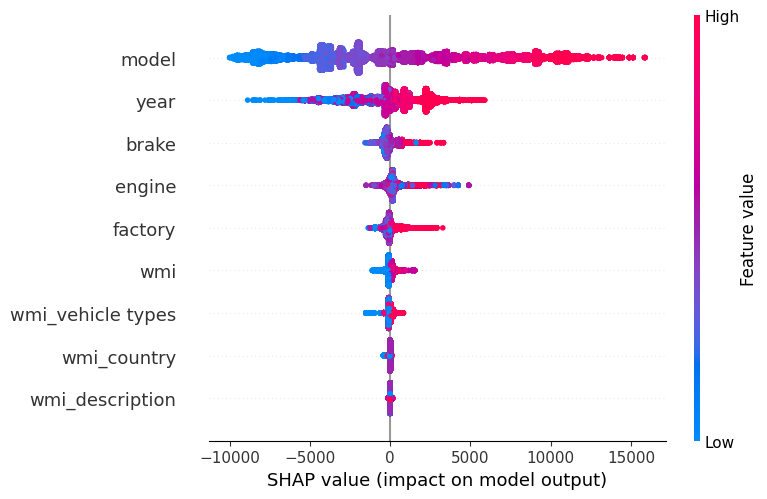

In [91]:
shap.summary_plot(shap_values, features_train)

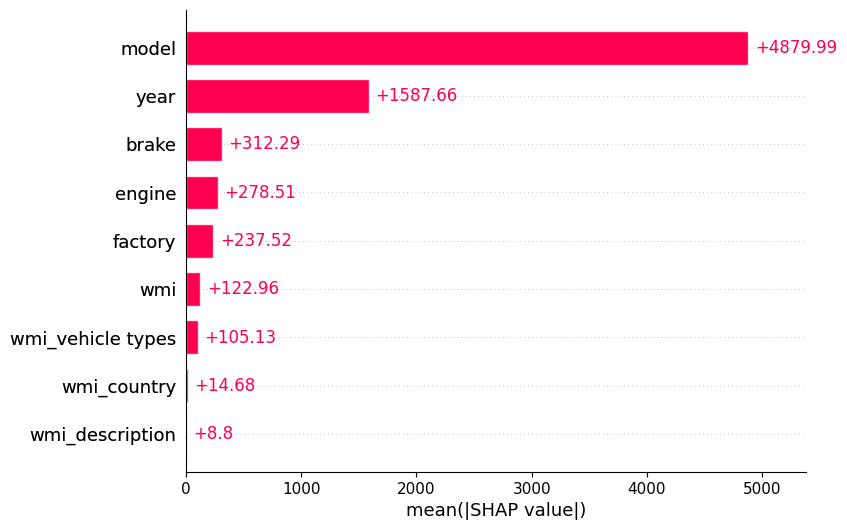

In [92]:
shap.plots.bar(shap_values)

Значительную важность для определения цены автомобиля имеют признаки: модель автомобиля (*model*) и год выпуска автомобиля (*year*). 

## Общий вывод

В нашем распоряжении имеются сырые данные по автомобилям Ford `vin_ford_train.txt` с VIN-кодами и ценами на автомобили, которым эти VIN-коды принадлежат. 

Составив регулярные выражения для поиска и извлечения конкретных частей VIN-кода, мы спарсили текстовый массив данных с VIN-кодами и ценами и получили необходимый датасет.

```
WMI = f'(?P<wmi>[{ALLOWED}]{{3}})'                                               # 1-3 производитель
BRAKE = f'(?P<brake>[{ALLOWED}])'                                                # 4 ремни безопасности, тормоза и грузоподъемность
MODEL = f'(?P<model>[{ALLOWED}]{{3}})'                                           # 5-7 модель
ENGINE = f'(?P<engine>[{ALLOWED}])'                                              # 8 двигатель
CHECK = f'(?P<check>[{ALLOWED}])'                                                # 9 контрольный знак
YEAR = f"(?P<year>[{ALLOWED.replace('U', '').replace('Z', '')}])"                # 10 год (в кодировке года не используются знаки U и Z)
FACTORY = f'(?P<factory>[{ALLOWED}])'                                            # 11 завод-производитель
SERIAL_NUM = f'(?P<serial_num>[{ALLOWED}]{{3}}\\d{{3}})'                         # 12-17 серийный номер

```

Изучили структуру VIN-кода, какие информационные компоненты он содержит (регион, производитель, характеристики автомобиля и т. д.).

Целью данного исследования была модель, которая будет предсказывать цену автомобиля по её VIN-коду.

Были выбраны следующие алгоритмы для обучения модели:

- `RandomForestRegressor`
- `CatBoostRegressor`
- `LGBMRegressor`

Качество моделей определялось метрикой *Mean Absolute Error (MAE)*. 

1. RandomForestRegressor 1931.152356
2. CatBoostRegressor 1921.324004
3. LGBMRegressor 1879.810175

Лучшая модель - LGBMRegressor с гиперпараметрами {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 26, 'force_col_wise': True} показала значение *MAE* на тестовой выборке = 1861, *RMSE* 2640
и *MAPE* 0.19

Наша обученная модель `LGBMRegressor` почти в 3 раза лучше константной `Dummy-модели`.

Значительную важность для определения цены автомобиля имеют признаки: модель автомобиля (*model*) и год выпуска автомобиля (*year*). 

Небольшой декодер. Принимает на вход VIN-код, если длина не совпадает, возвращает "Неверный VIN-код", если длина ок, возвращает датафрейм с расшифровкой.

Пример правильного кода VIN: 2FMDK3JC4BBA41556

In [ ]:
# Небольшой декодер

v = input()
vin = re.compile(vin_ford)
def decode_vin(s):
    if len(v) == 17:
        return pd.DataFrame([x.groupdict() for x in vin.finditer(s)]);
    else:
        print('Неверный VIN-код')
    
df_1 = decode_vin(v)
df_1